In [7]:
import pandas as pd
import sys
sys.path.append("../lib")
import seaborn as sns
import matplotlib.pyplot as plt
from utils import iterate_over
from utils import load_config_and_check
from inspector import Inspector
from tqdm import tqdm
import os

In [2]:
config = load_config_and_check("../config/experiment_v12.yaml")

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
FOLDER_PROGRAM_INFO = os.path.join(config["experiment_folder"], "cross_platform", "programs", "cirq")
all_records = []
for program_id, document in iterate_over(
                                folder=FOLDER_PROGRAM_INFO, 
                                filetype=".json", 
                                parse_json=True):
    all_records.append(document)
    
df_info = pd.DataFrame.from_records(all_records)

In [4]:
FOLDER_DETECTION = os.path.join(config["experiment_folder"], "cross_platform", "predictions")
all_detectors = os.listdir(FOLDER_DETECTION)
all_records = [] 

assert config["n_executions"] == 1
# we assume there is only one executions per program
# platform a vs b only once

for detector_name in all_detectors:
    path_detector = os.path.join(FOLDER_DETECTION, detector_name)
    
    for program_id, content in tqdm(iterate_over(path_detector, filetype=".json", parse_json=True)):
        comparison = content.pop("comparisons")
        new_content = {**content, **comparison[0]}
        all_records.append(new_content)
        
df = pd.DataFrame.from_records(all_records)

In [5]:
df.head()

test      test_long_name comparison_name circuit_id  random_seed  \
0  fast_energy  Faster Energy Test  cross_platform       9076       4321.0   
1  fast_energy  Faster Energy Test  cross_platform       2313       4321.0   
2  fast_energy  Faster Energy Test  cross_platform       1235       4321.0   
3  fast_energy  Faster Energy Test  cross_platform       6029       4321.0   
4  fast_energy  Faster Energy Test  cross_platform       5887       4321.0   

  platform_a platform_b                                        path_exec_a  \
0       cirq     qiskit  ../data/experiment_v12/cross_platform/executio...   
1       cirq     qiskit  ../data/experiment_v12/cross_platform/executio...   
2       cirq     qiskit  ../data/experiment_v12/cross_platform/executio...   
3       cirq     qiskit  ../data/experiment_v12/cross_platform/executio...   
4       cirq     qiskit  ../data/experiment_v12/cross_platform/executio...   

                                         path_exec_b      time  statistic  \
0  ../data/experiment_v12/cross_platform/executio...  0.145341   0.000181   
1  ../data/experiment_v12/cross_platform/executio...  0.207075   0.000262   
2  ../data/experiment_v12/cross_platform/executio...  0.136157   0.000400   
3  ../data/experiment_v12/cross_platform/executio...  0.575500   0.000493   
4  ../data/experiment_v12/cross_platform/executio...  0.145701   0.000188   

   p_value  
0      1.0  
1      1.0  
2      1.0  
3      1.0  
4      1.0

In [8]:
df[["circuit_id", "test", "statistic"]].head(10)

circuit_id         test  statistic
0       9076  fast_energy   0.000181
1       2313  fast_energy   0.000262
2       1235  fast_energy   0.000400
3       6029  fast_energy   0.000493
4       5887  fast_energy   0.000188
5        715  fast_energy   0.000722
6        115  fast_energy   0.000714
7       6991  fast_energy   0.000620
8       5560  fast_energy   0.000765
9       8097  fast_energy   0.000117

coefficient: 0.47504966243580876, p_value: 0.0


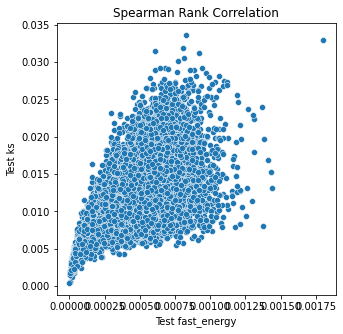

In [9]:
from scipy.stats import spearmanr


def compare_correlation(df, test_1, test_2):
    df = df[["circuit_id", "test", "statistic"]]
    df_1 = df[df["test"] == test_1]
    df_2 = df[df["test"] == test_2]
    df_join = pd.merge(
        df_1, df_2, on="circuit_id"
    )
    coefficient, p_value = spearmanr(df_join["statistic_x"], df_join["statistic_y"])
    print(f"coefficient: {coefficient}, p_value: {p_value}")
    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(
        data=df_join,
        x='statistic_x',
        y='statistic_y',
        ax=ax
    )
    ax.set_xlabel(f"Test {test_1}")
    ax.set_ylabel(f"Test {test_2}")
    ax.set_title("Spearman Rank Correlation")
    
    

#compare_correlation(df, test_1="energy", test_2="fast_energy")

compare_correlation(df, test_1="fast_energy", test_2="ks")

<AxesSubplot:xlabel='test', ylabel='time'>

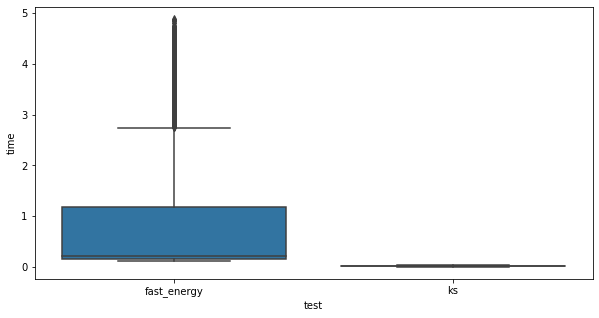

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(
    data=df,
    y='time',
    x='test',
    ax=ax
)

## Inspect one of those divergent cases

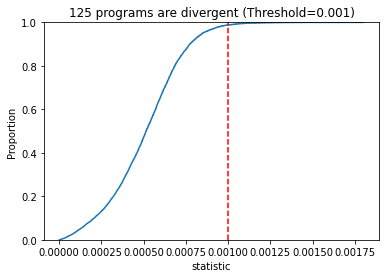

In [40]:
THRESHOLD = 0.001

df_single_test = df[df["test"] == "fast_energy"]

ax = sns.ecdfplot(
    data=df_single_test,
    x='statistic',
)

cases_above_threshold = len(df_single_test[df_single_test["statistic"] > THRESHOLD])
ax.set_title(f"{cases_above_threshold} programs are divergent (Threshold={THRESHOLD})")
ax.axvline(x=THRESHOLD, c='red', linestyle="--")

In [41]:
TOP_K = cases_above_threshold

most_serious_divergent_cases = list(df_single_test.sort_values(by="statistic", ascending=False)["circuit_id"])
most_serious_divergent_cases = [int(e) for e in most_serious_divergent_cases]
if len(most_serious_divergent_cases) > TOP_K:
    most_serious_divergent_cases = most_serious_divergent_cases[:TOP_K]

In [42]:
most_serious_divergent_cases


[4205,
 8444,
 3363,
 5783,
 7026,
 8447,
 4881,
 2971,
 9488,
 3570,
 4760,
 1419,
 7100,
 7132,
 5759,
 1887,
 7188,
 6119,
 4730,
 989,
 765,
 1676,
 8486,
 1940,
 8265,
 8454,
 8741,
 3956,
 9444,
 7544,
 1361,
 9221,
 9736,
 9016,
 6848,
 4198,
 5057,
 5643,
 2887,
 133,
 5475,
 6802,
 7628,
 8546,
 7351,
 694,
 1418,
 4567,
 9149,
 9006,
 7317,
 9589,
 7130,
 9743,
 5851,
 217,
 7143,
 6342,
 6074,
 5708,
 801,
 6241,
 8409,
 7111,
 451,
 5362,
 9005,
 7699,
 9853,
 2796,
 168,
 1573,
 7563,
 3629,
 4537,
 4370,
 7530,
 2733,
 8980,
 4871,
 5434,
 7797,
 5989,
 3451,
 1131,
 5953,
 4604,
 2065,
 4423,
 2506,
 1627,
 6470,
 9563,
 9055,
 7591,
 3265,
 8908,
 9872,
 6616,
 8239,
 8112,
 3355,
 8488,
 2028,
 1866,
 6359,
 5765,
 8827,
 7574,
 3000,
 1602,
 6028,
 2405,
 3545,
 7625,
 6893,
 3383,
 5241,
 7824,
 2813,
 4687,
 6319,
 9725,
 7409,
 3704]

In [37]:
df_info = df_info.assign(circuit_id=lambda d: d['circuit_id'].astype(int))
df_most_serious = df_info[df_info["circuit_id"].isin(most_serious_divergent_cases)]
df_most_serious = df_most_serious.sort_values(by=["n_ops", "n_qubits"], ascending=True)
df_most_serious.head(TOP_K)

n_qubits  n_ops                                      gate_set  \
4623        17     40  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
8274        14     45  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
3028        18     63  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
5950        17     72  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
41          10     85  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
7574        17     89  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
4610         9    100  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
1845         8    101  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
1034        19    101  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
3464        12    106  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
6042        17    106  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
5104        16    110  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
5904         2    115  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
8588        20    116  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
8996        20    123  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
417         18    125  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
6378        20    127  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
1930        20    152  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
9887        14    170  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   
1349        18    182  {'cx': 3, 'rx': 1, 'ry': 1, 'rz': 1, 'p': 1}   

         strategy_program_generation  circuit_id  benchmark_name  
4623  WeightedRandomCircuitGenerator        8444  cross_platform  
8274  WeightedRandomCircuitGenerator        4881  cross_platform  
3028  WeightedRandomCircuitGenerator        4760  cross_platform  
5950  WeightedRandomCircuitGenerator        3570  cross_platform  
41    WeightedRandomCircuitGenerator        3363  cross_platform  
7574  WeightedRandomCircuitGenerator        7026  cross_platform  
4610  WeightedRandomCircuitGenerator        2971  cross_platform  
1845  WeightedRandomCircuitGenerator        5783  cross_platform  
1034  WeightedRandomCircuitGenerator        9488  cross_platform  
3464  WeightedRandomCircuitGenerator        7188  cross_platform  
6042  WeightedRandomCircuitGenerator        7100  cross_platform  
5104  WeightedRandomCircuitGenerator        4730  cross_platform  
5904  WeightedRandomCircuitGenerator        4205  cross_platform  
8588  WeightedRandomCircuitGenerator         989  cross_platform  
8996  WeightedRandomCircuitGenerator        7132  cross_platform  
417   WeightedRandomCircuitGenerator        1419  cross_platform  
6378  WeightedRandomCircuitGenerator        8447  cross_platform  
1930  WeightedRandomCircuitGenerator        6119  cross_platform  
9887  WeightedRandomCircuitGenerator        5759  cross_platform  
1349  WeightedRandomCircuitGenerator        1887  cross_platform

In [18]:
#ID_TO_INSPECT = 26 in experiment v11
ID_TO_INSPECT = most_serious_divergent_cases[0]

In [19]:
FOLDER_EXECUTION = os.path.join(config["experiment_folder"], "cross_platform", "executions")
sherlock = Inspector(
    folder_executions=FOLDER_EXECUTION,
    platform_names=['qiskit', 'cirq']
)

Program id: 4205
n_qubits: 2
n_shots: 8192.0
Uniform threshold: 2048.0


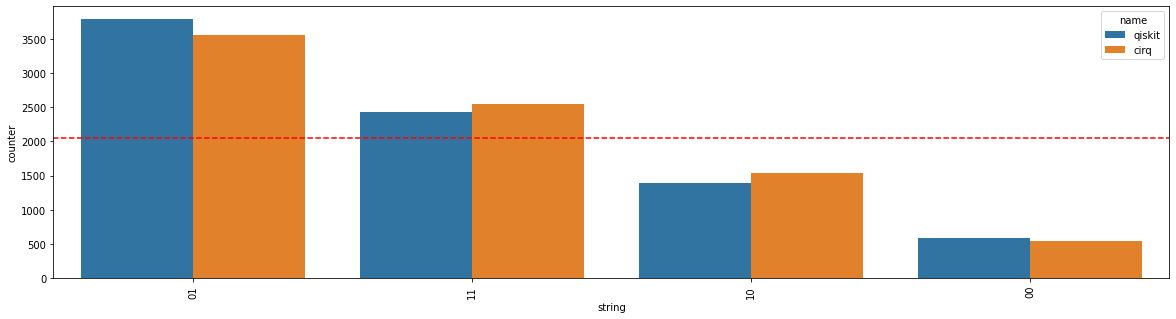

Program id: 8444
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


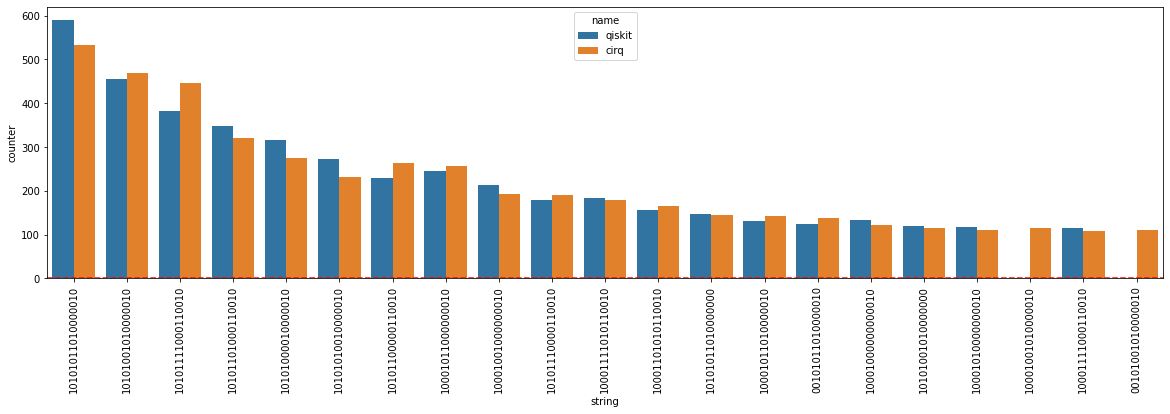

Program id: 3363
n_qubits: 10
n_shots: 8192.0
Uniform threshold: 8.0


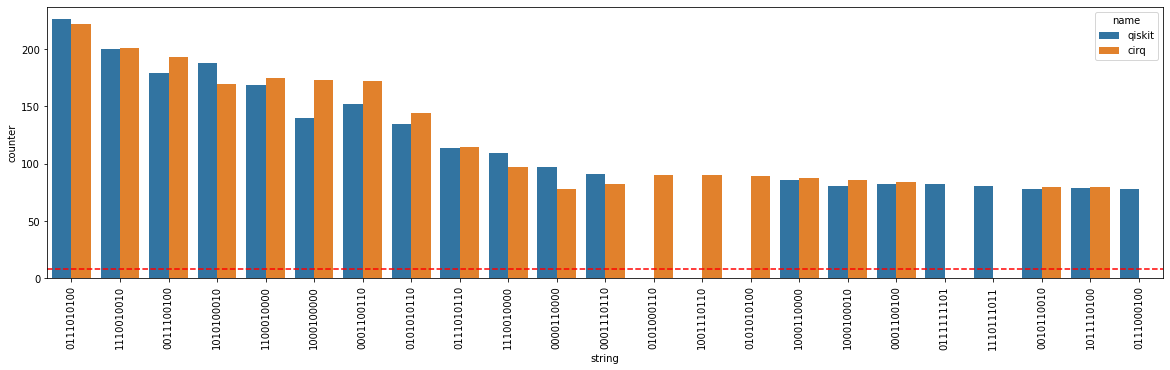

Program id: 5783
n_qubits: 8
n_shots: 8192.0
Uniform threshold: 32.0


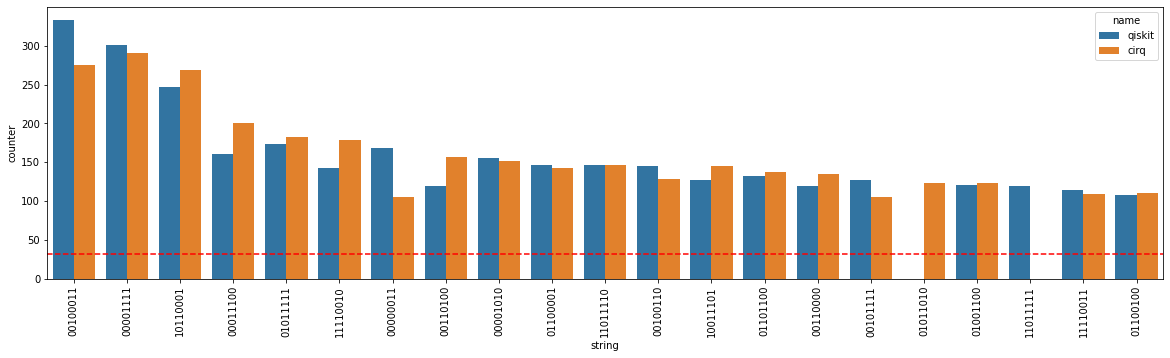

Program id: 7026
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


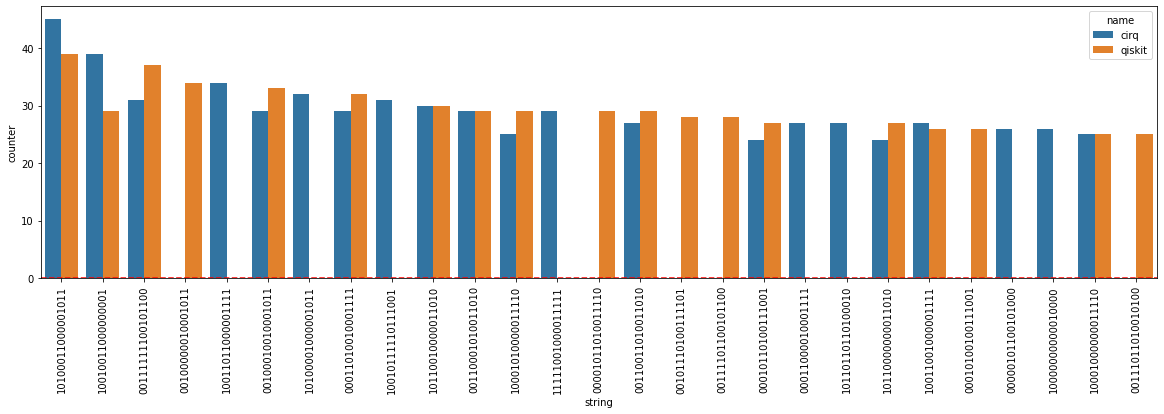

Program id: 8447
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


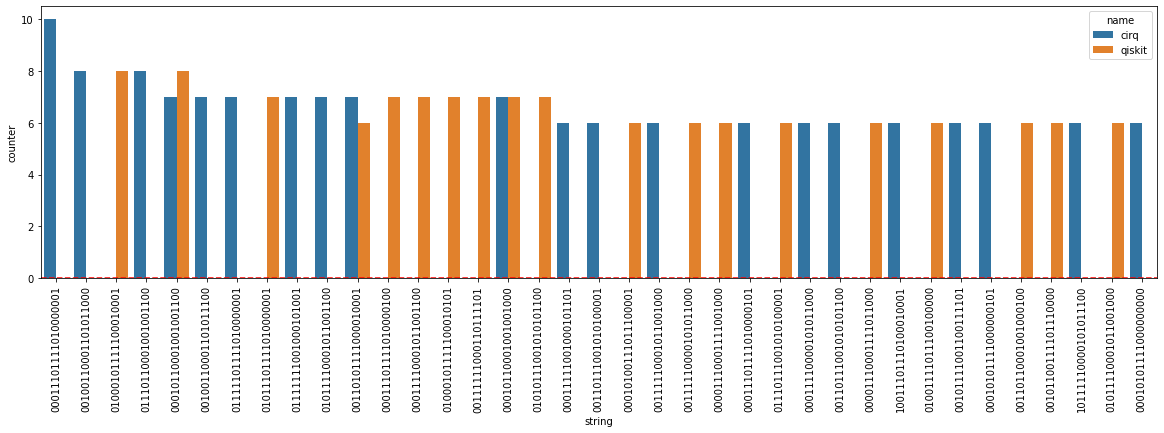

Program id: 4881
n_qubits: 14
n_shots: 8192.0
Uniform threshold: 0.5


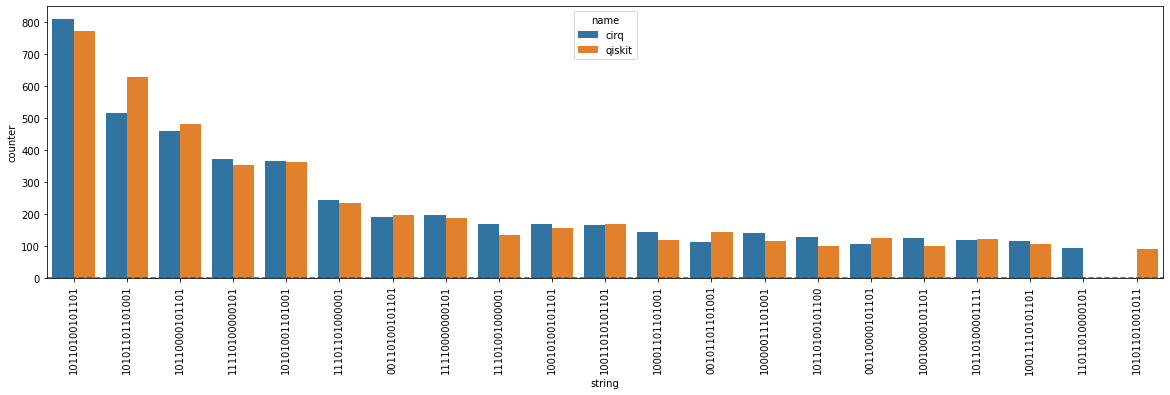

Program id: 2971
n_qubits: 9
n_shots: 8192.0
Uniform threshold: 16.0


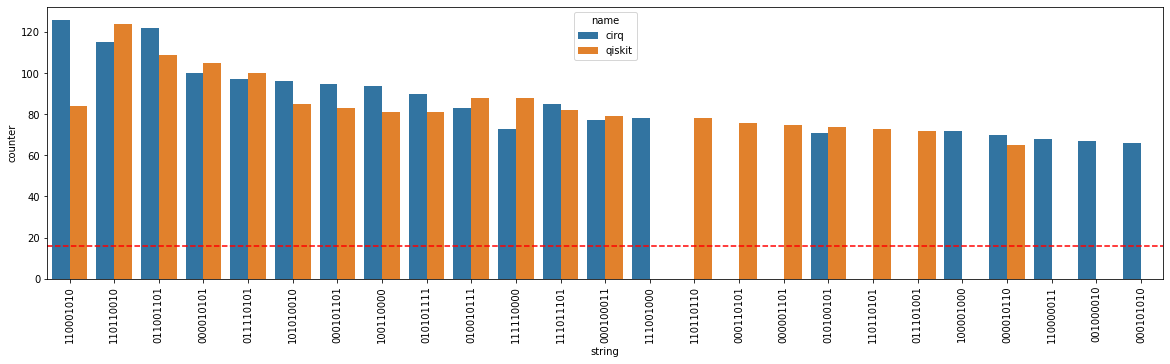

Program id: 9488
n_qubits: 19
n_shots: 8192.0
Uniform threshold: 0.015625


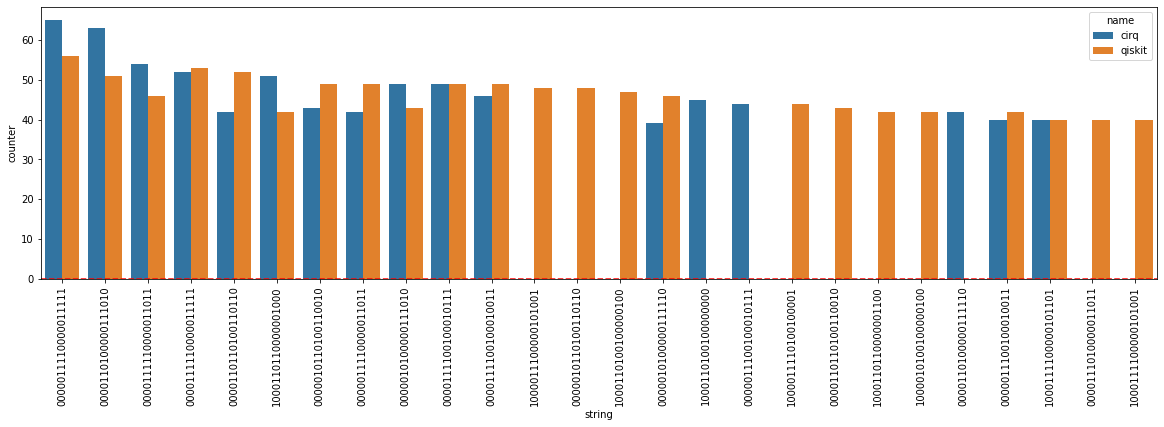

Program id: 3570
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


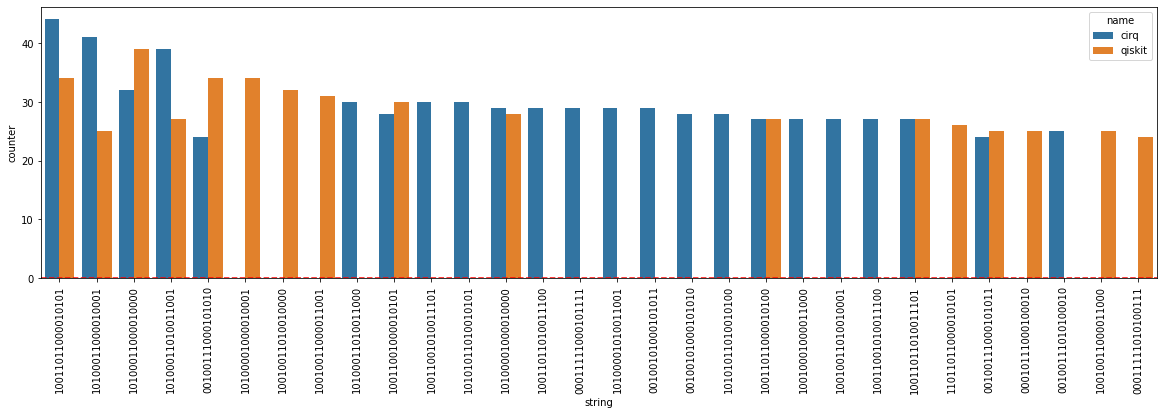

Program id: 4760
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


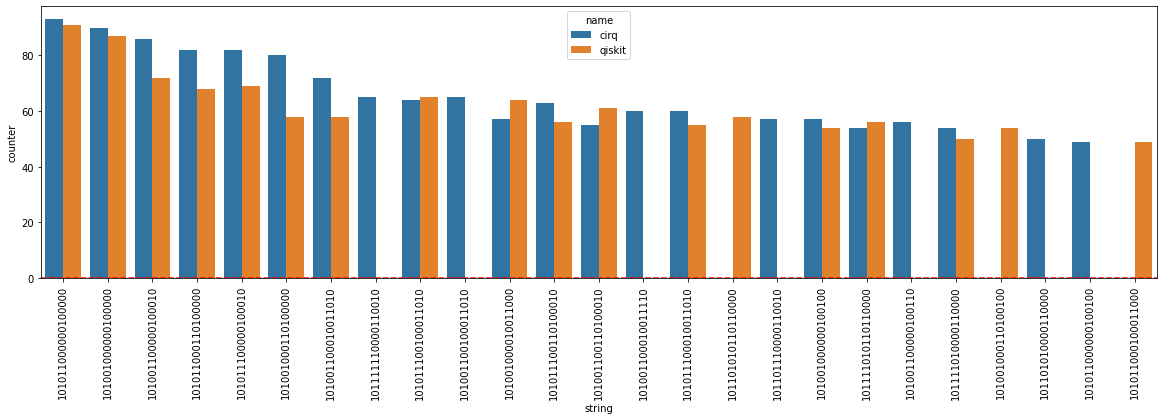

Program id: 1419
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


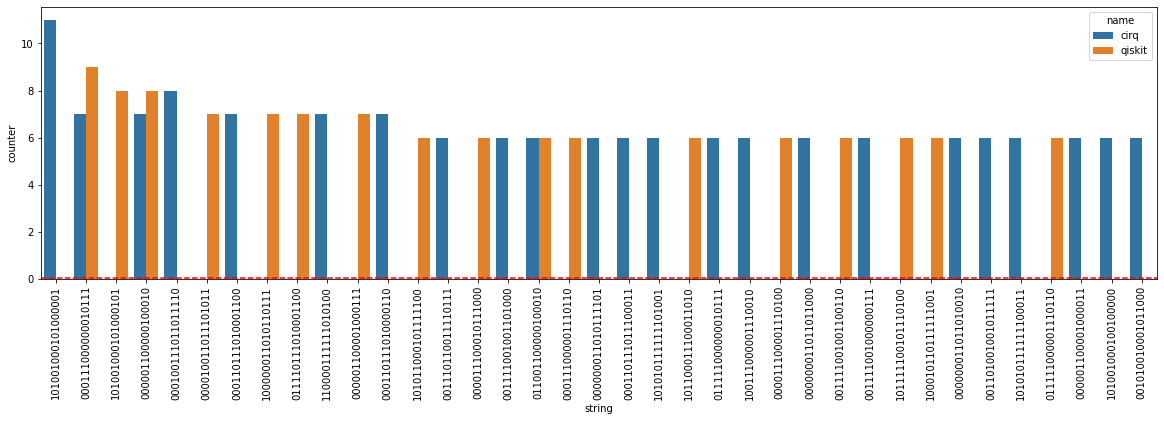

Program id: 7100
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


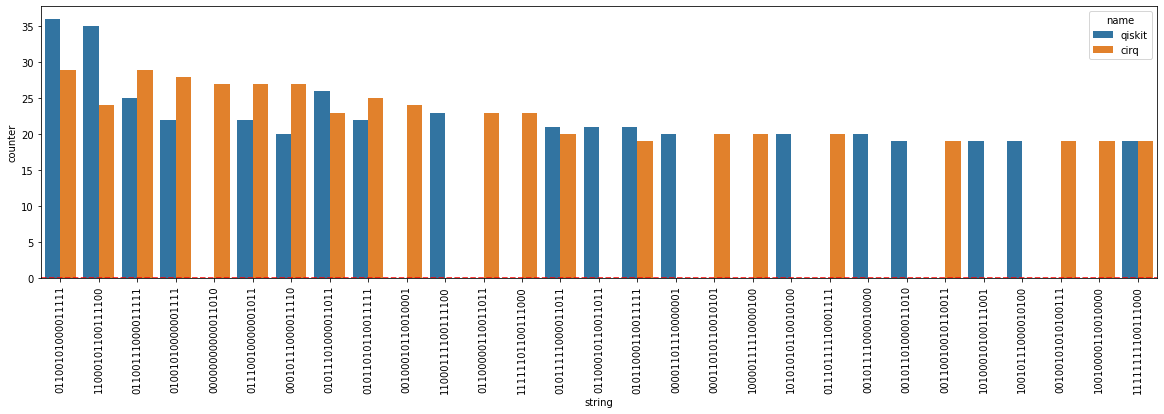

Program id: 7132
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


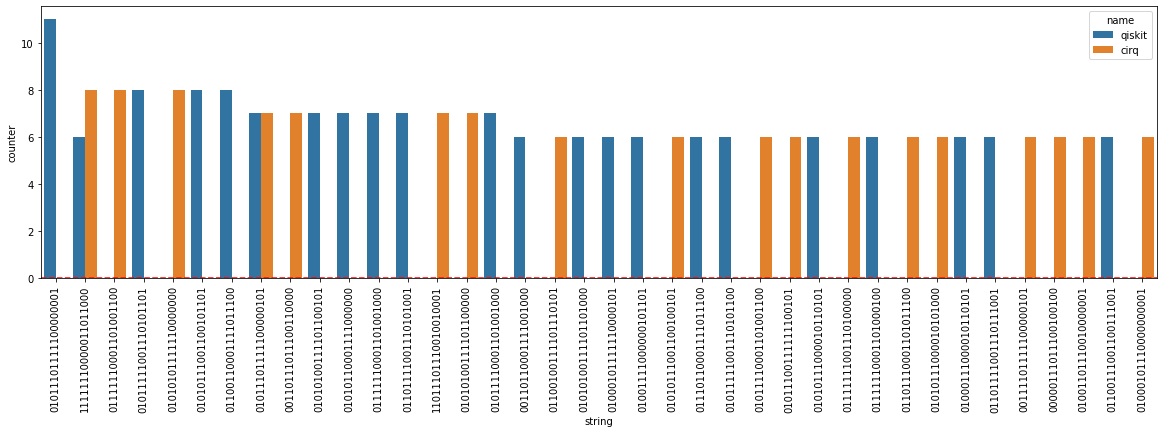

Program id: 5759
n_qubits: 14
n_shots: 8192.0
Uniform threshold: 0.5


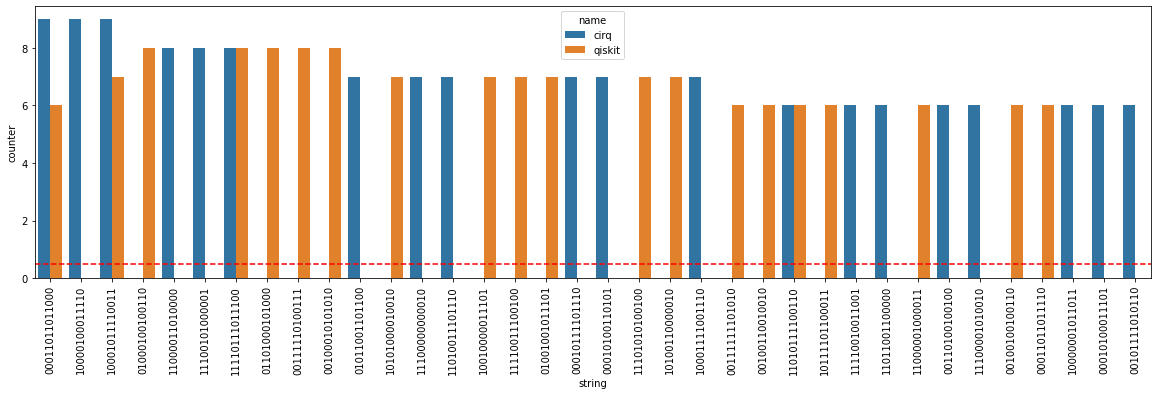

Program id: 1887
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


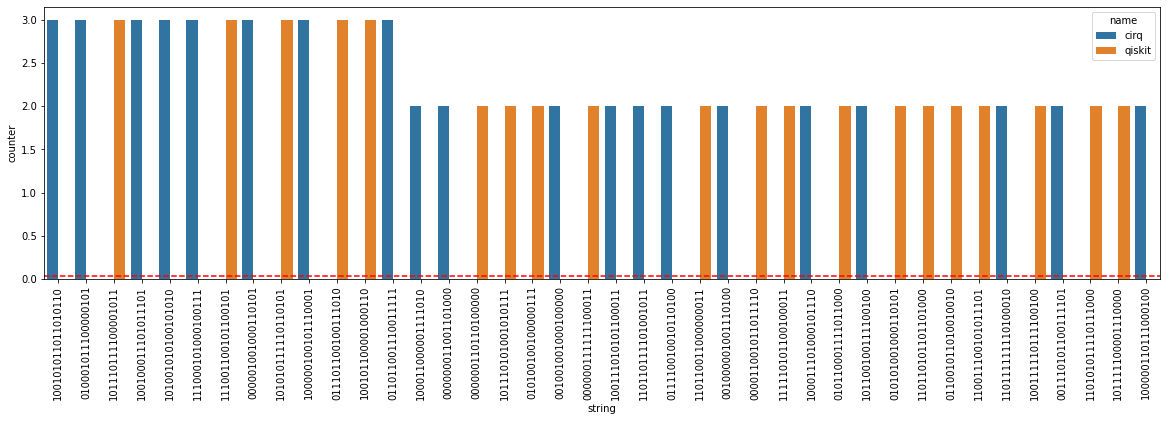

Program id: 7188
n_qubits: 12
n_shots: 8192.0
Uniform threshold: 2.0


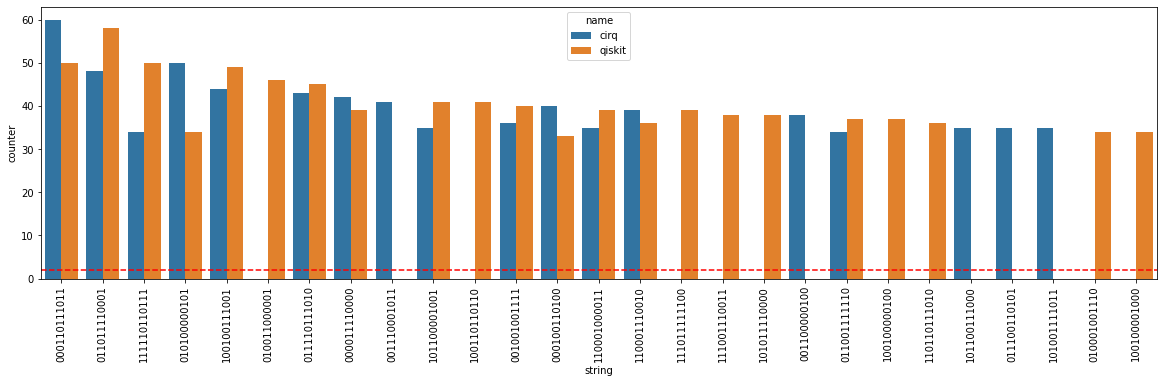

Program id: 6119
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


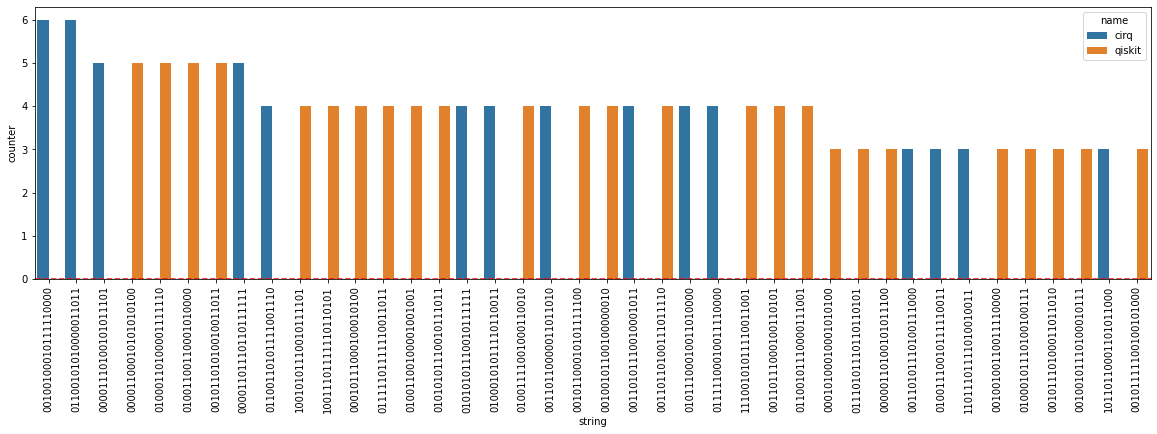

Program id: 4730
n_qubits: 16
n_shots: 8192.0
Uniform threshold: 0.125


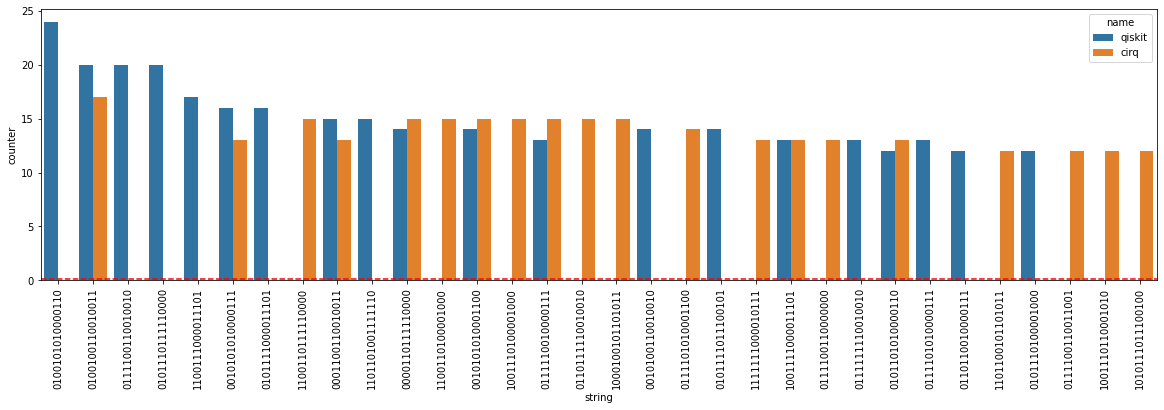

Program id: 989
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


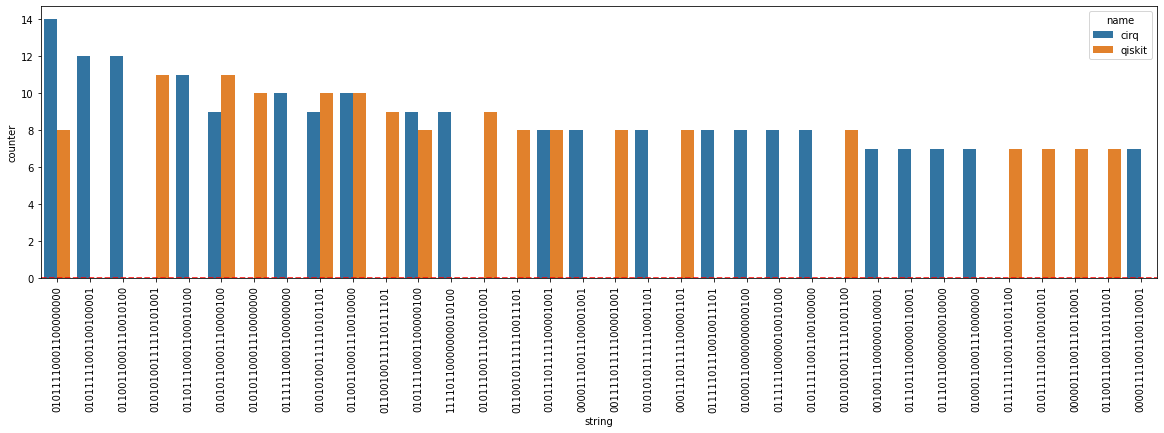

Program id: 765
n_qubits: 2
n_shots: 8192.0
Uniform threshold: 2048.0


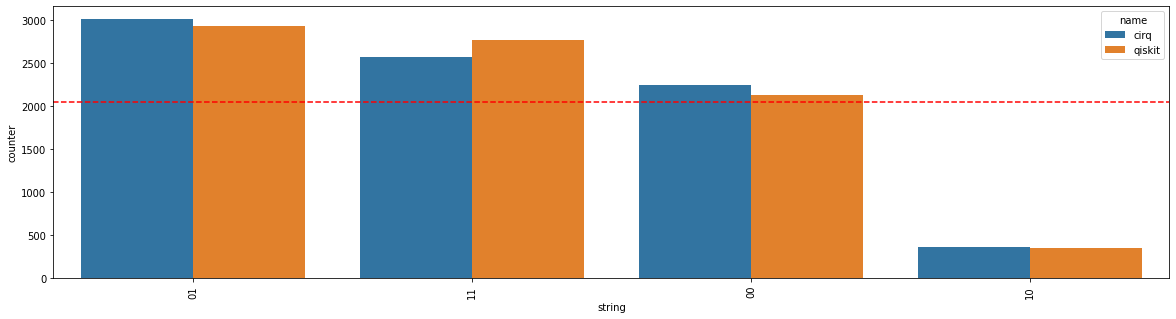

Program id: 1676
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


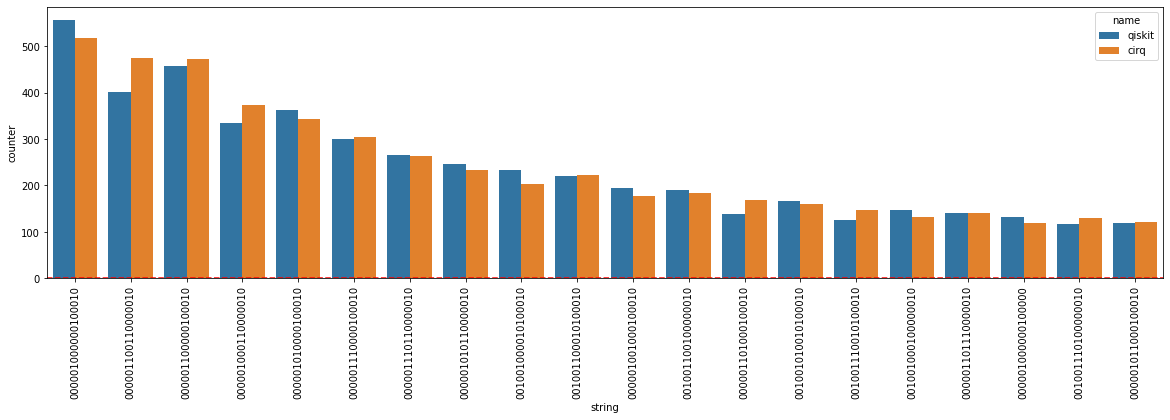

Program id: 8486
n_qubits: 10
n_shots: 8192.0
Uniform threshold: 8.0


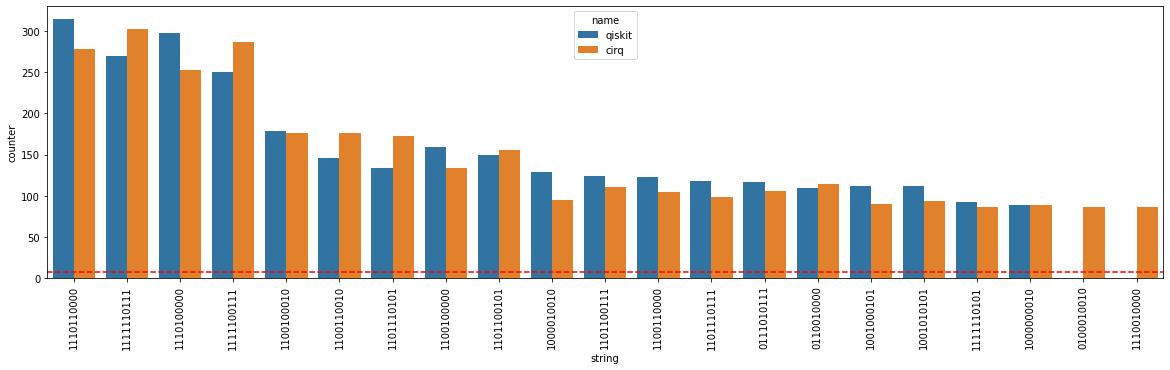

Program id: 1940
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


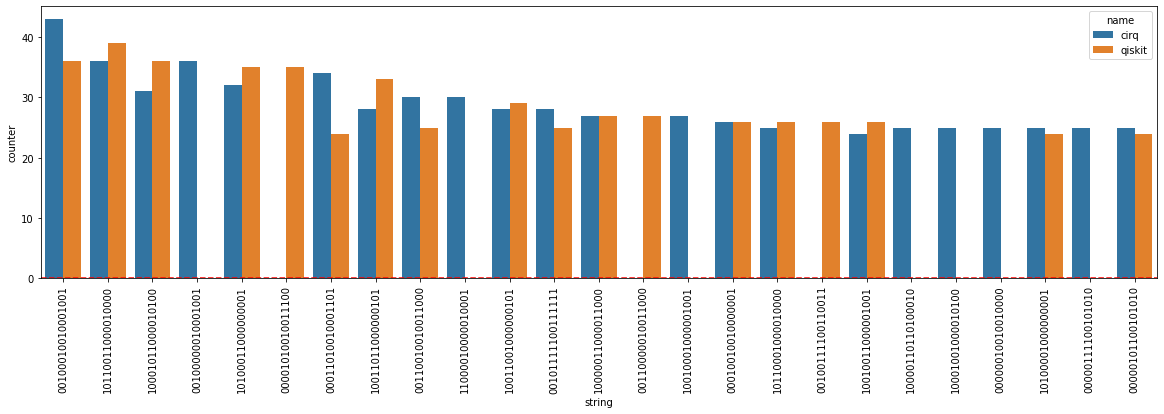

Program id: 8265
n_qubits: 5
n_shots: 8192.0
Uniform threshold: 256.0


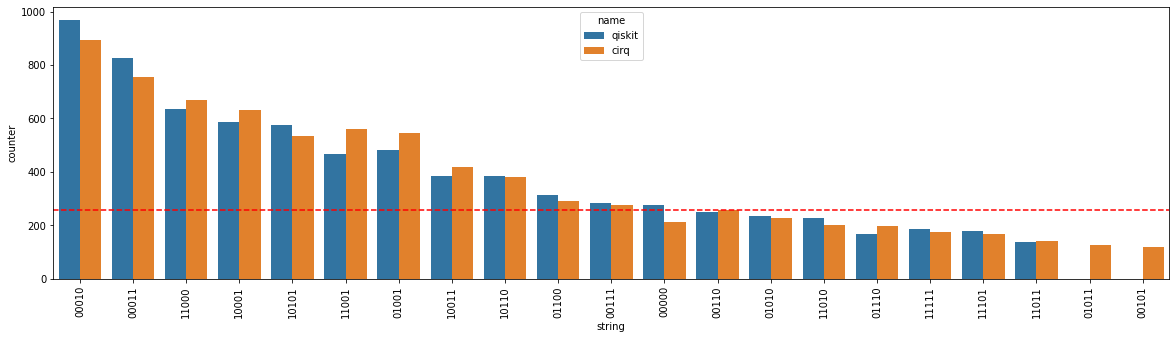

Program id: 8454
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


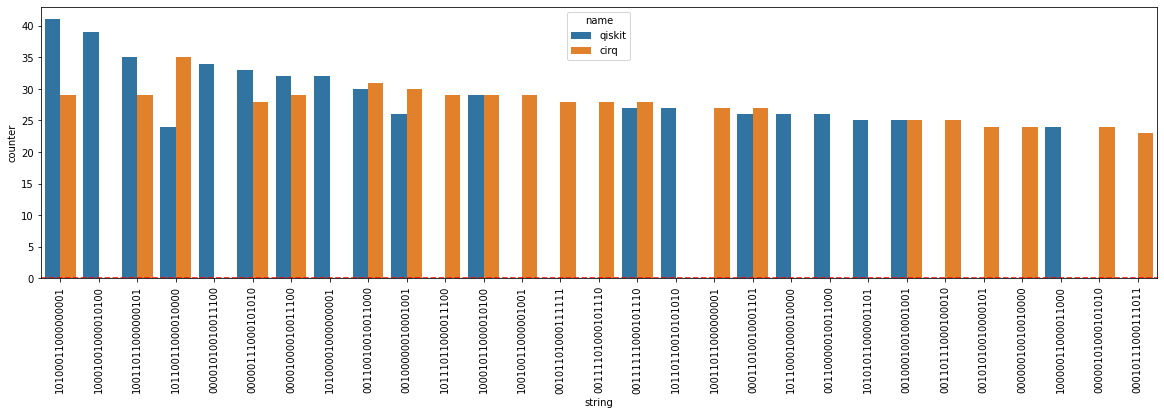

Program id: 8741
n_qubits: 15
n_shots: 8192.0
Uniform threshold: 0.25


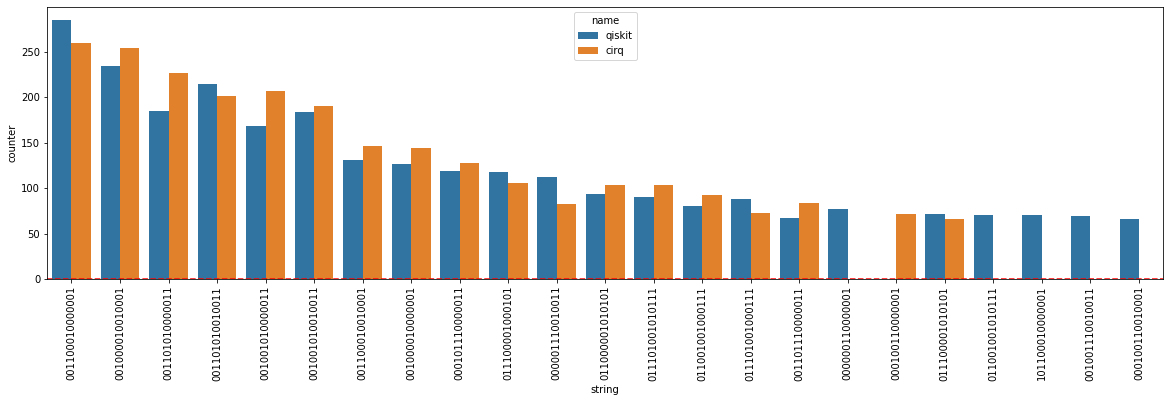

Program id: 3956
n_qubits: 9
n_shots: 8192.0
Uniform threshold: 16.0


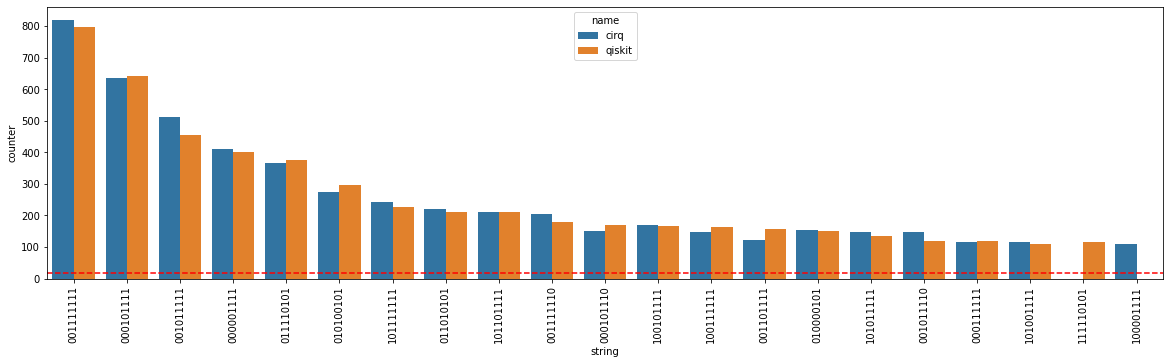

Program id: 9444
n_qubits: 6
n_shots: 8192.0
Uniform threshold: 128.0


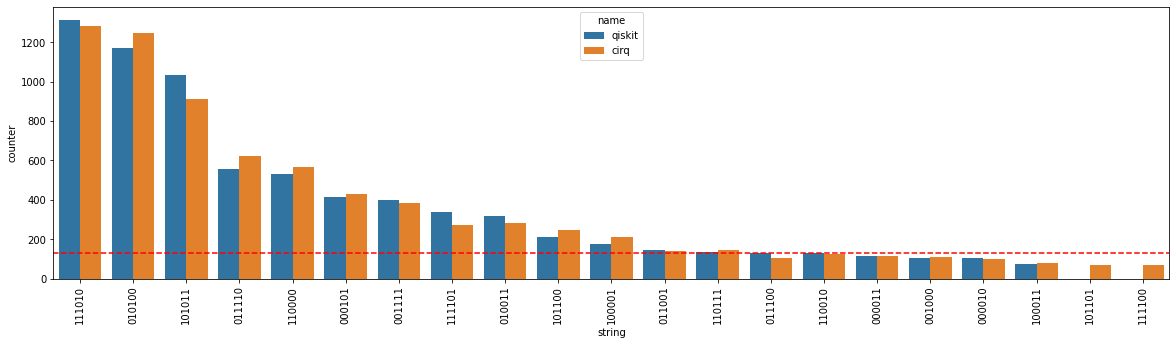

Program id: 7544
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


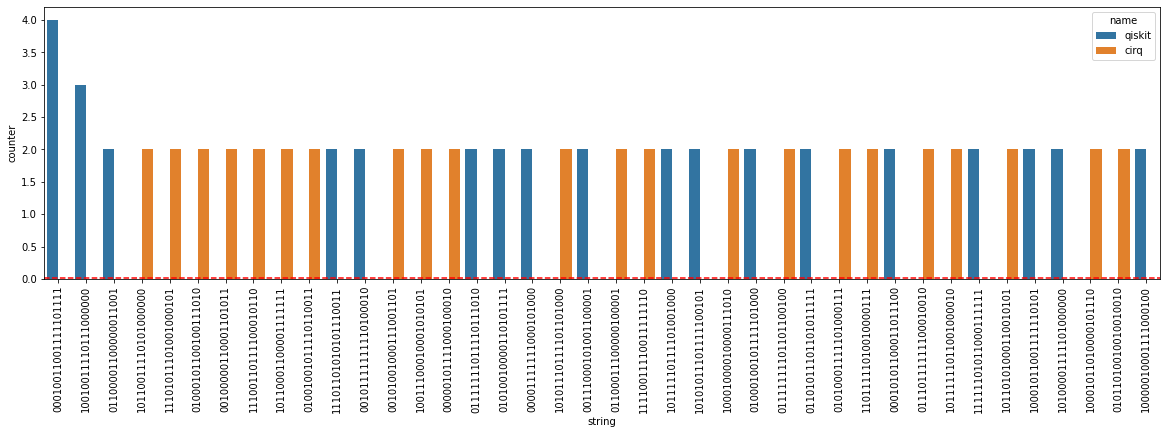

Program id: 1361
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


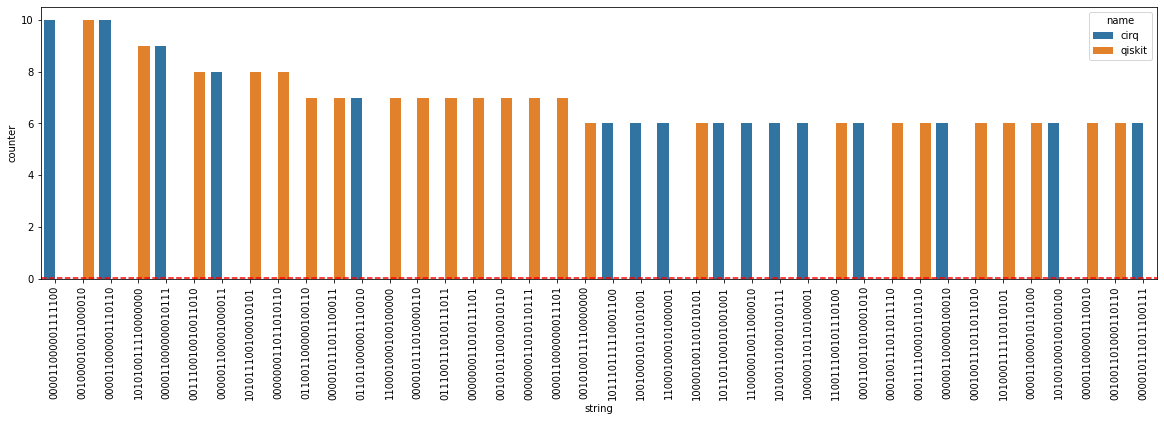

Program id: 9221
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


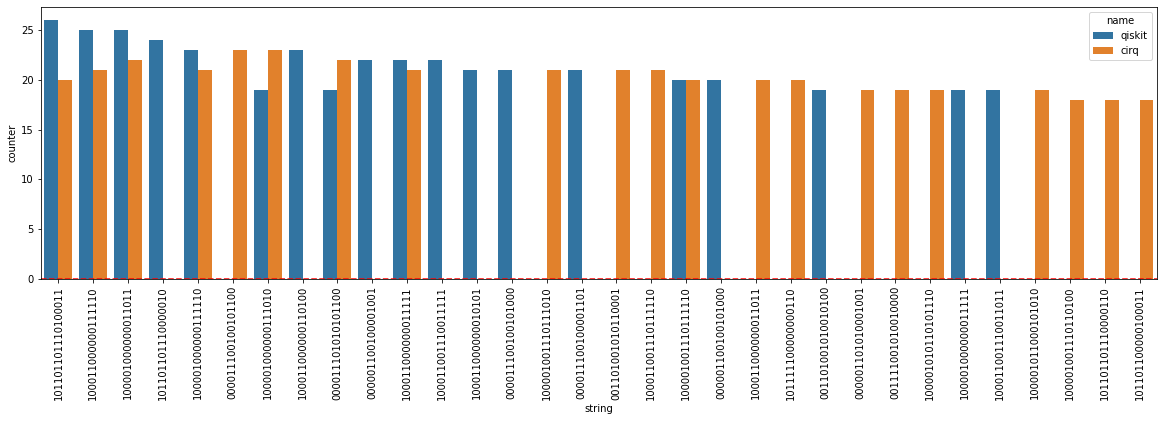

Program id: 9736
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


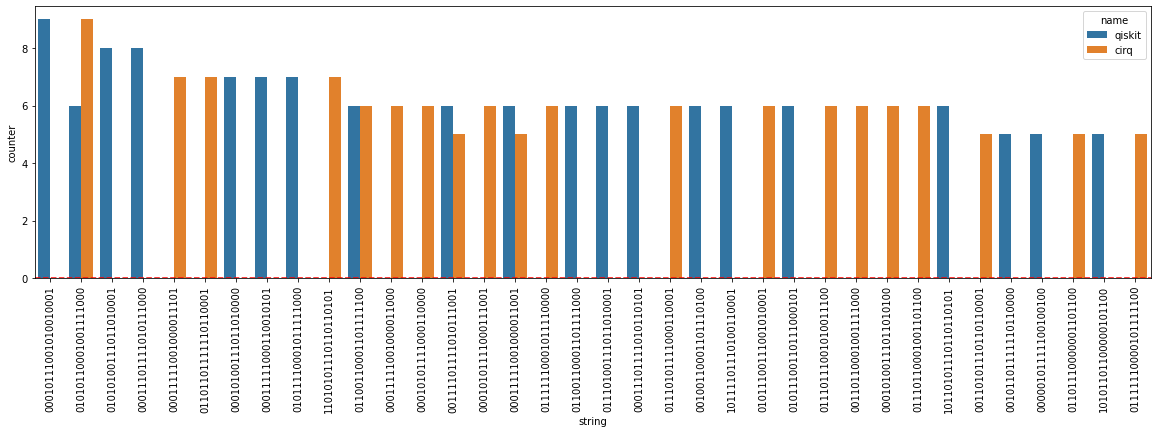

Program id: 9016
n_qubits: 13
n_shots: 8192.0
Uniform threshold: 1.0


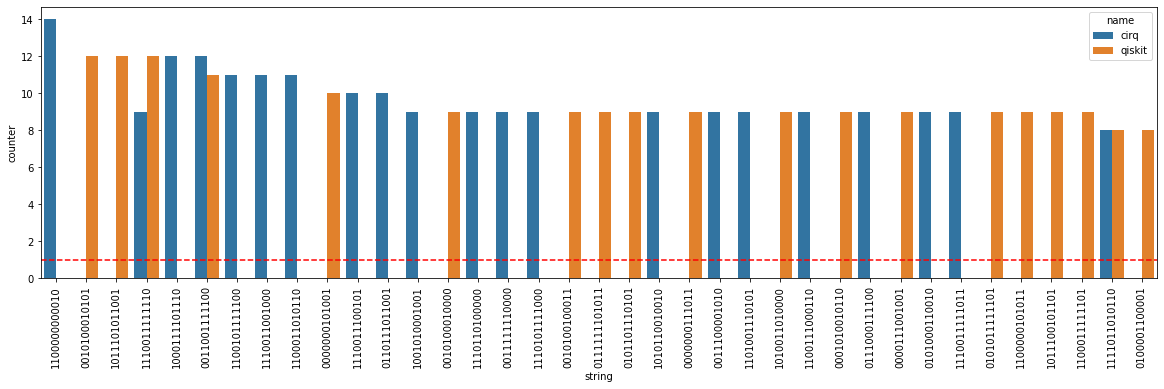

Program id: 6848
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


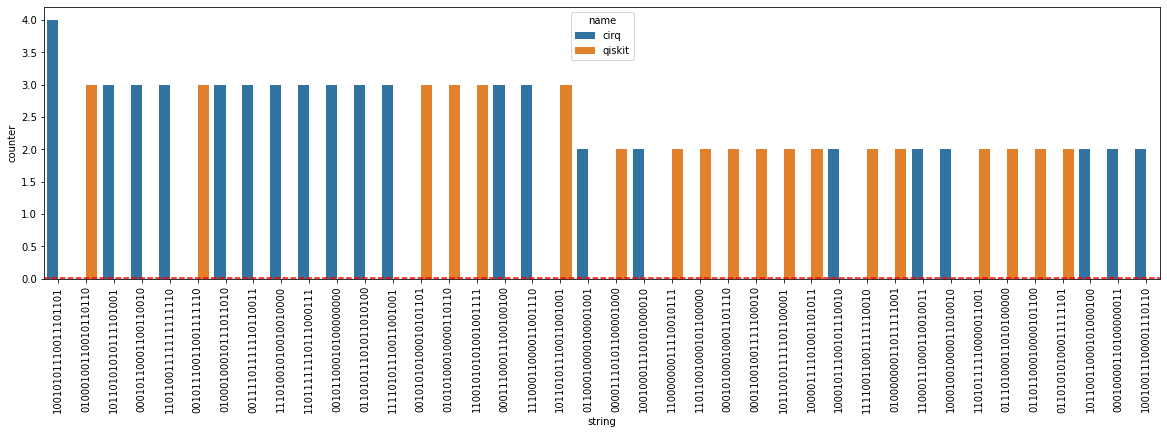

Program id: 4198
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


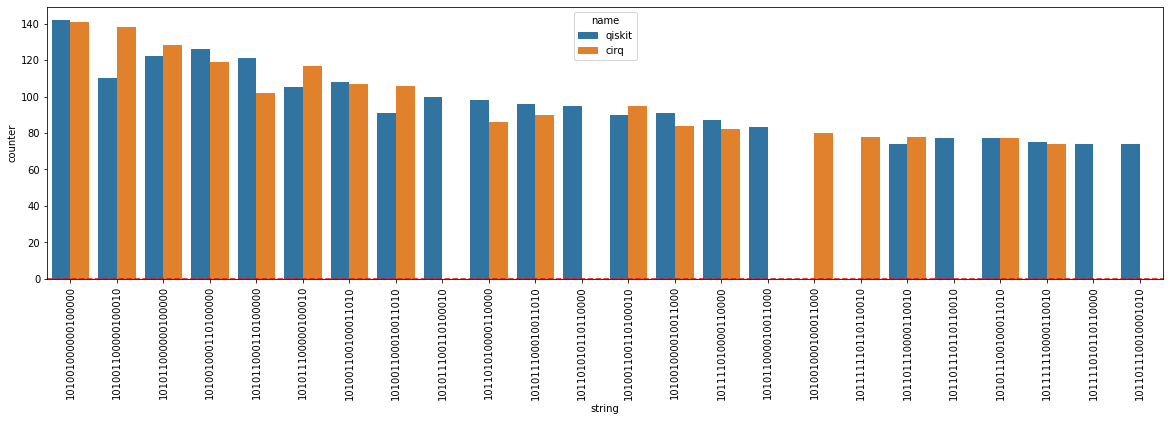

Program id: 5057
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


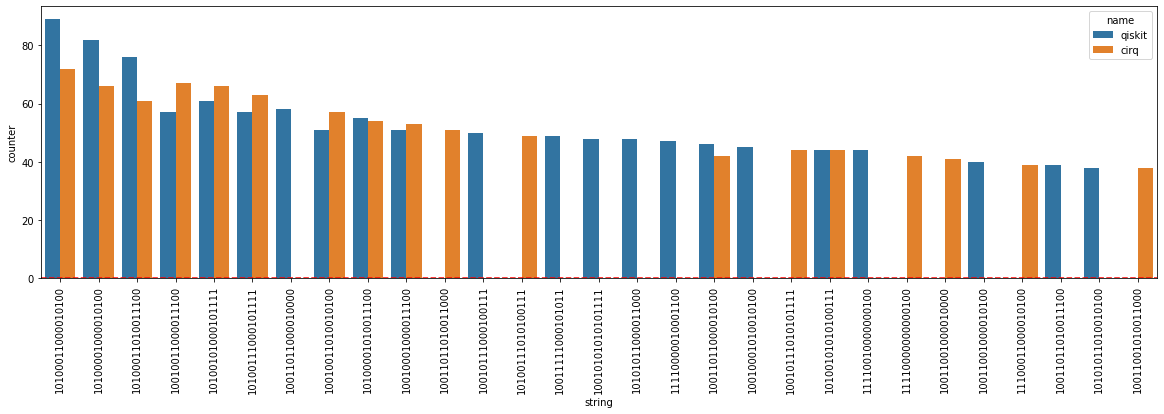

Program id: 5643
n_qubits: 13
n_shots: 8192.0
Uniform threshold: 1.0


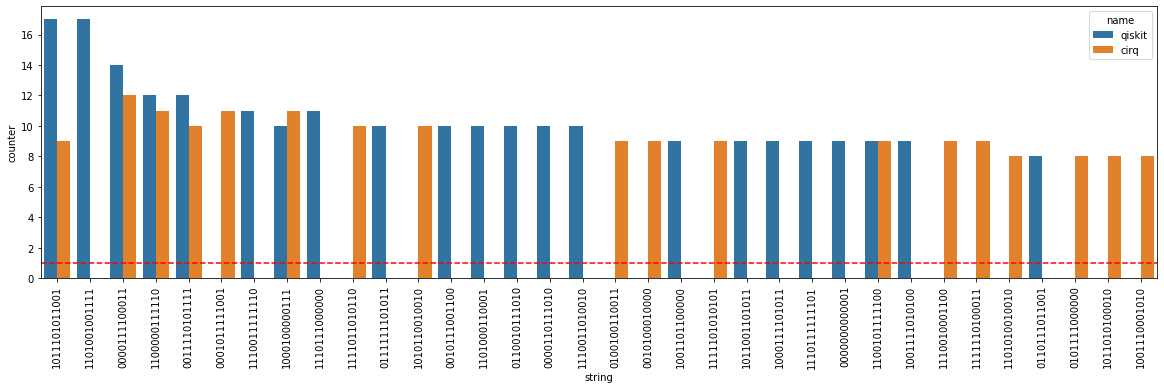

Program id: 2887
n_qubits: 13
n_shots: 8192.0
Uniform threshold: 1.0


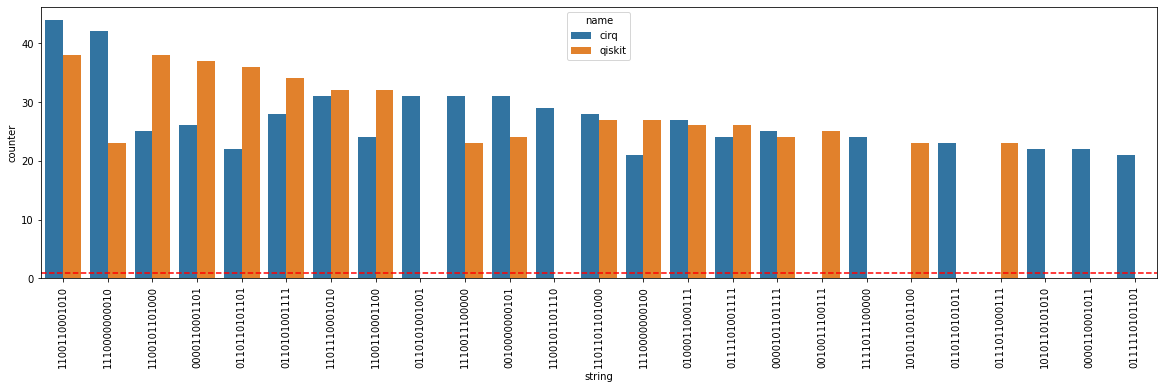

Program id: 133
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


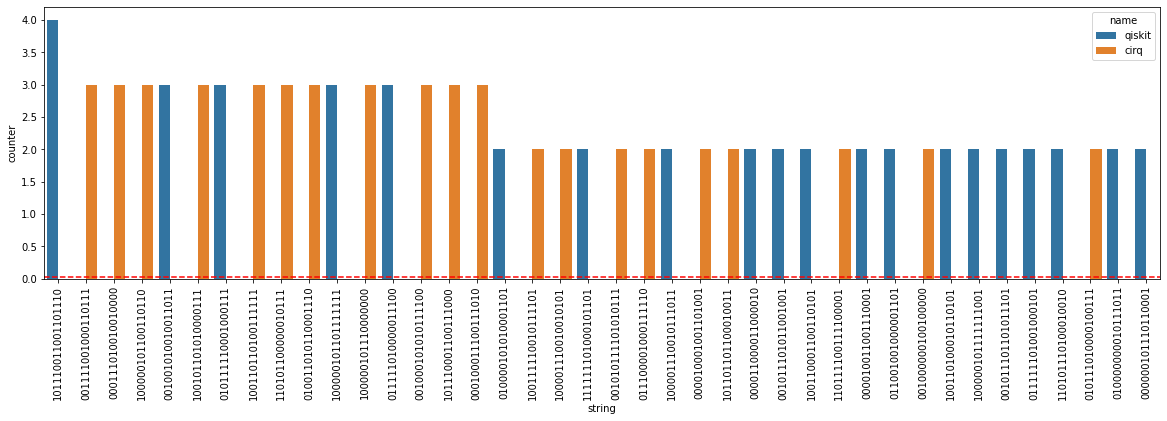

Program id: 5475
n_qubits: 19
n_shots: 8192.0
Uniform threshold: 0.015625


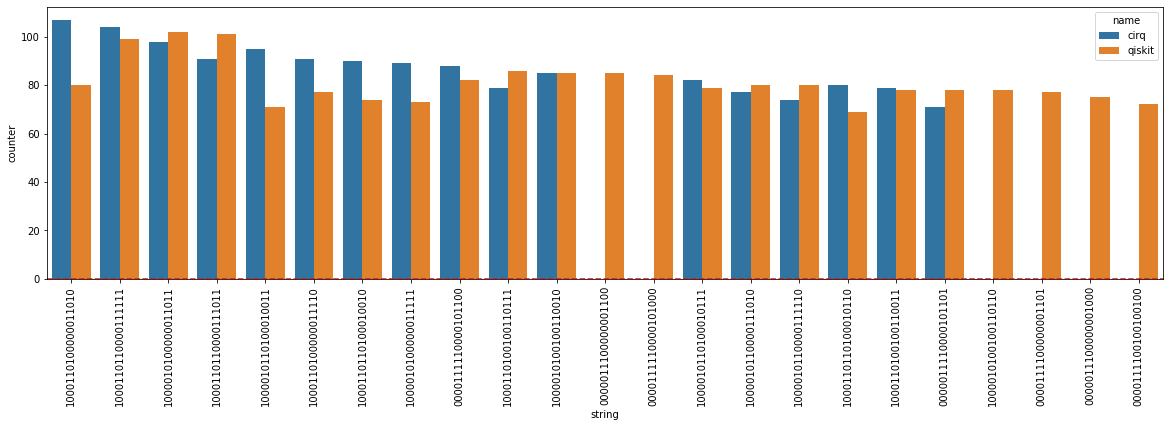

Program id: 6802
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


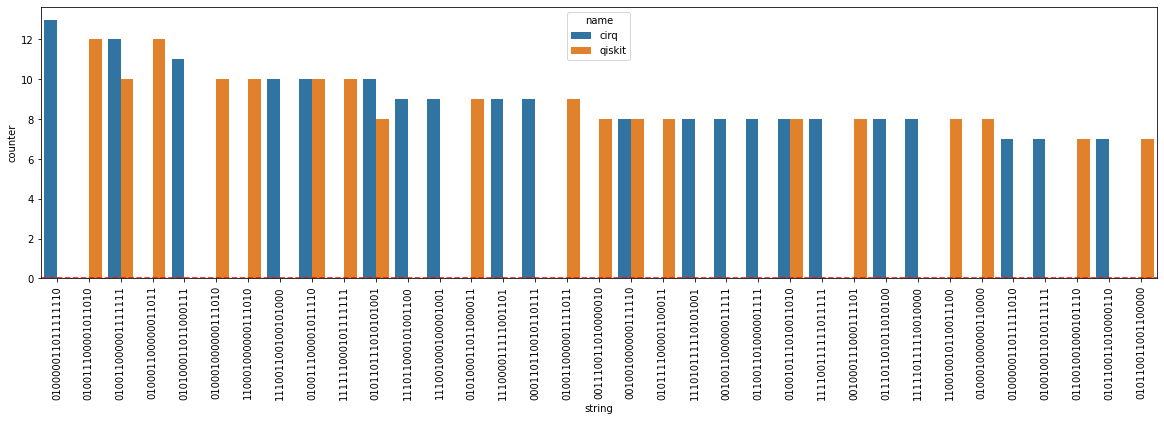

Program id: 7628
n_qubits: 3
n_shots: 8192.0
Uniform threshold: 1024.0


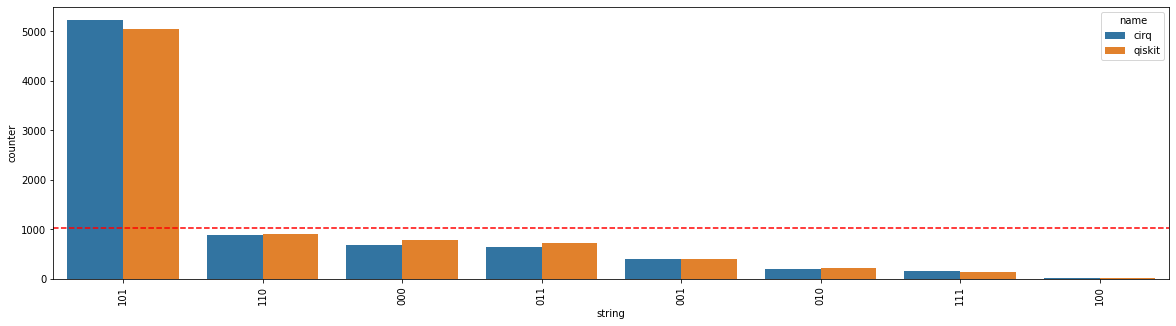

Program id: 8546
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


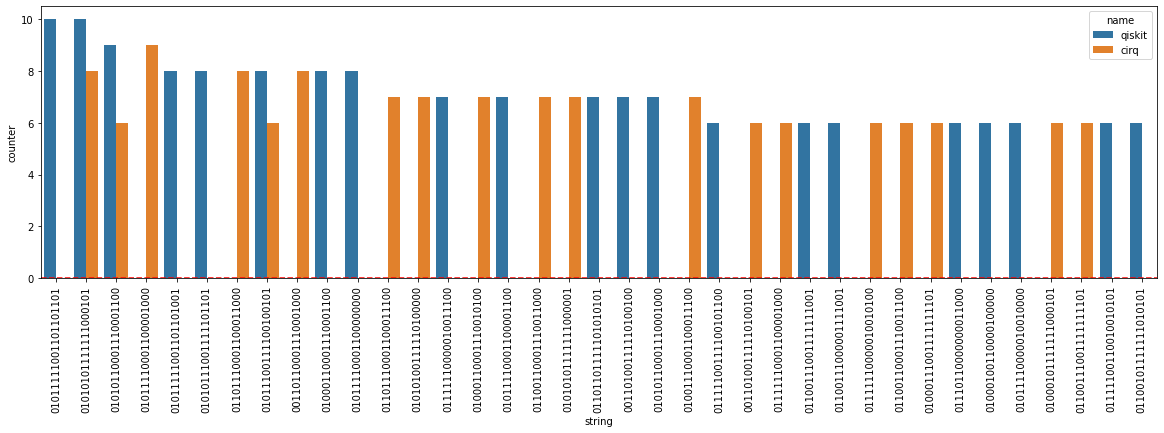

Program id: 7351
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


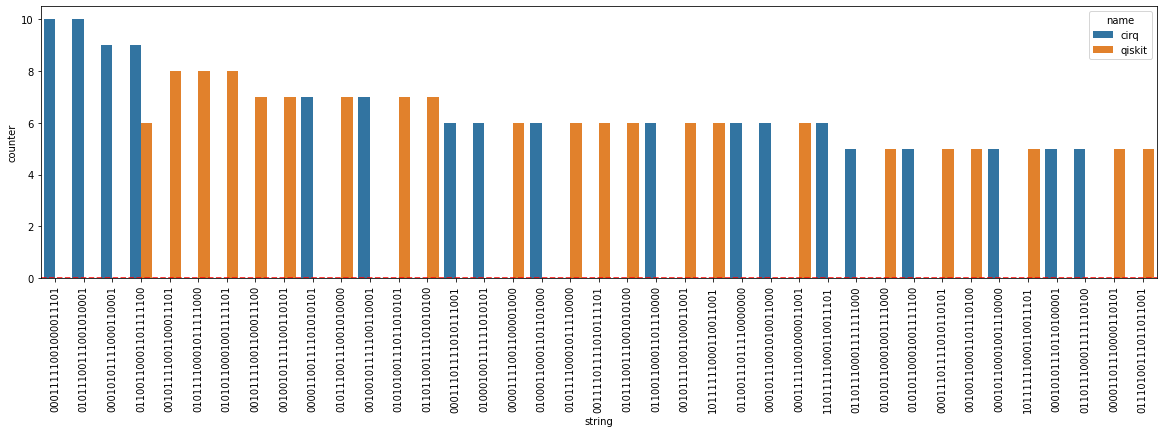

Program id: 694
n_qubits: 3
n_shots: 8192.0
Uniform threshold: 1024.0


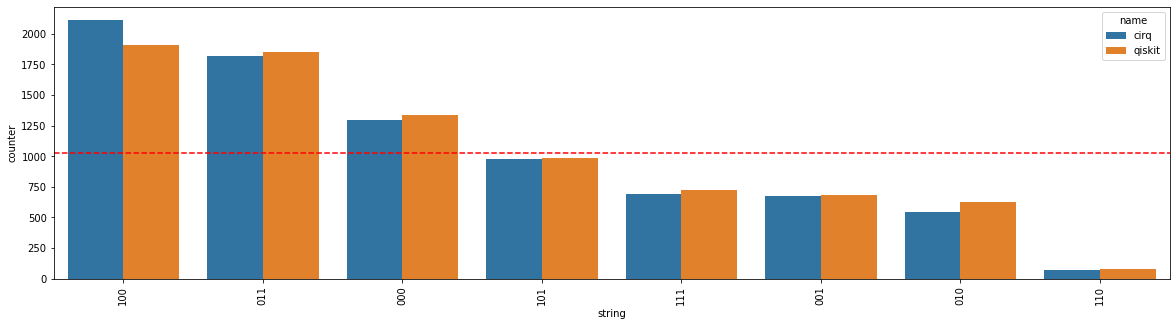

Program id: 1418
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


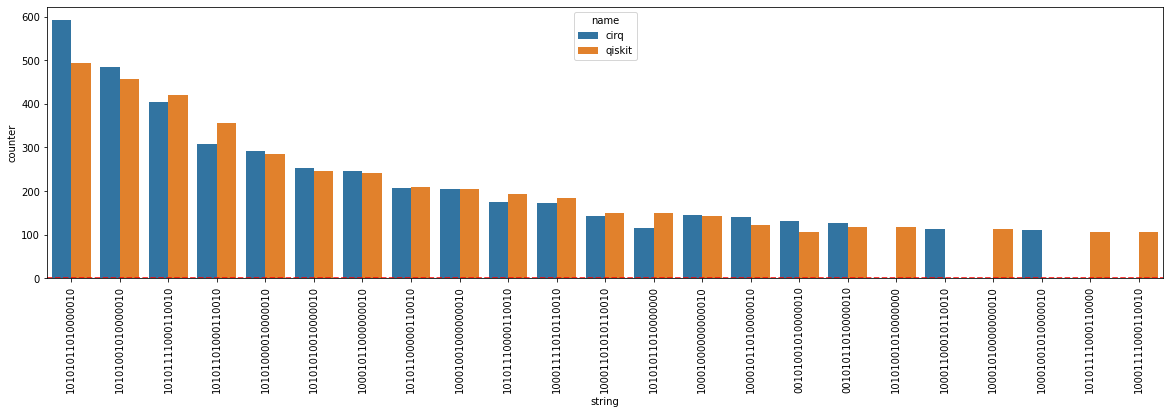

Program id: 4567
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


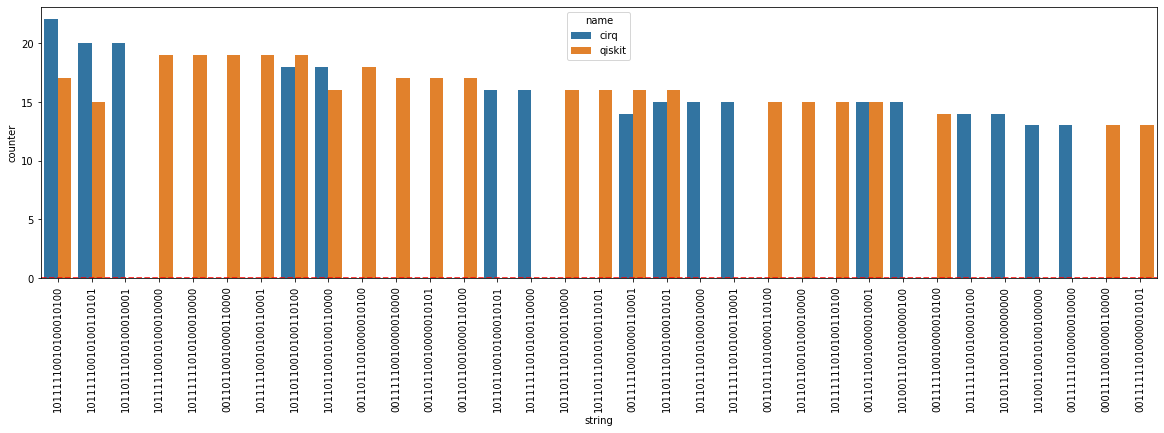

Program id: 9149
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


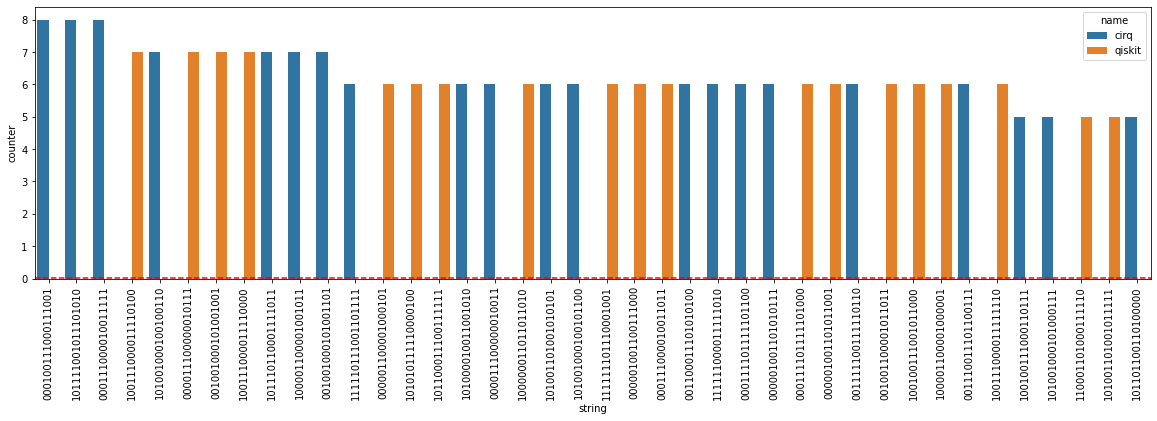

Program id: 9006
n_qubits: 14
n_shots: 8192.0
Uniform threshold: 0.5


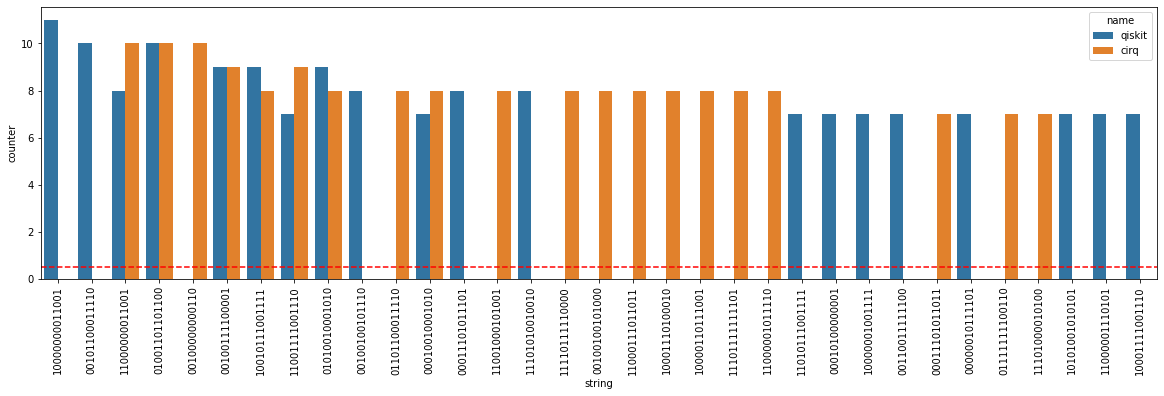

Program id: 7317
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


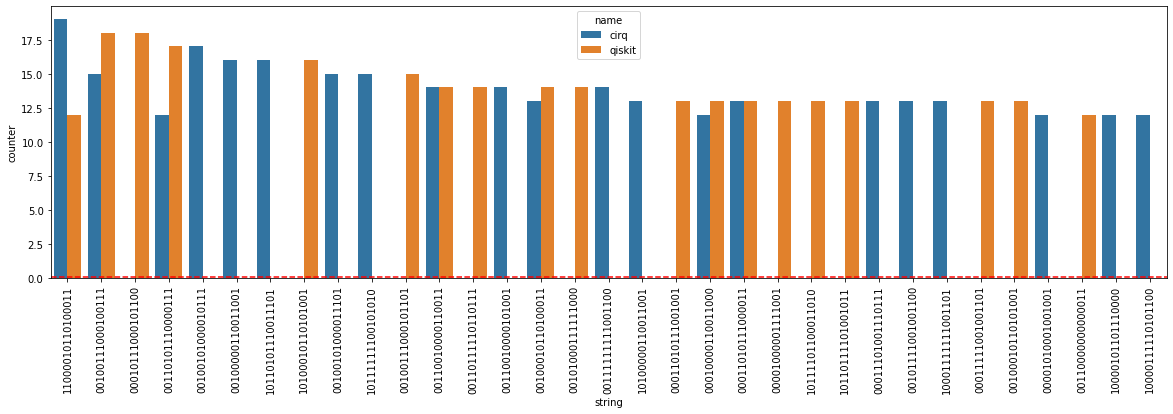

Program id: 9589
n_qubits: 15
n_shots: 8192.0
Uniform threshold: 0.25


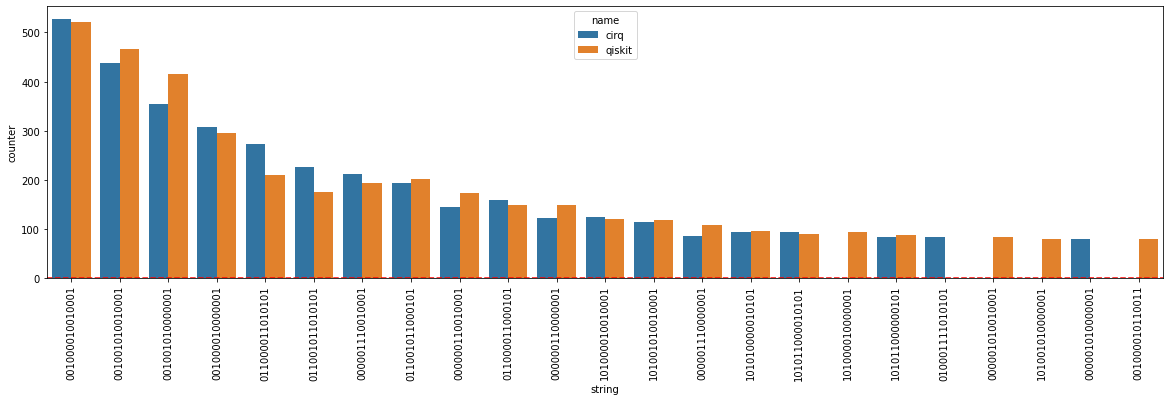

Program id: 7130
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


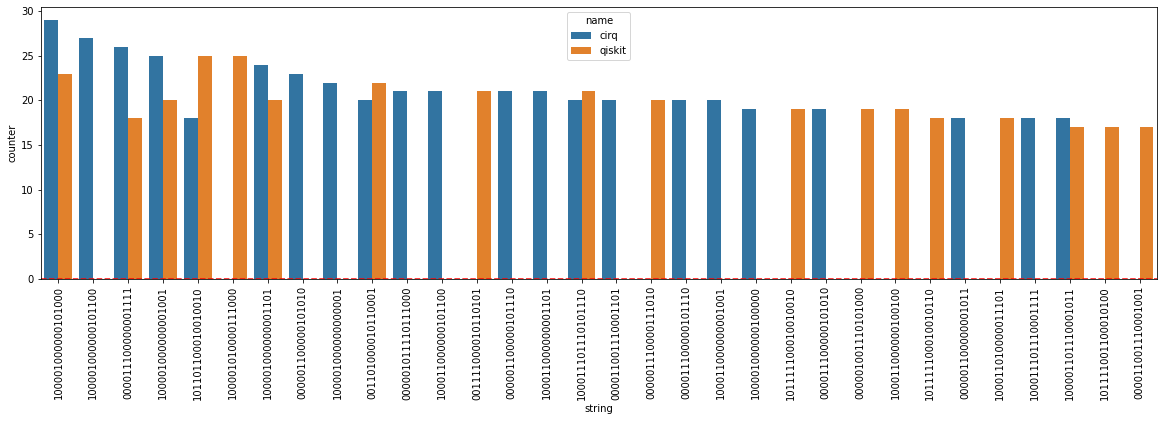

Program id: 9743
n_qubits: 16
n_shots: 8192.0
Uniform threshold: 0.125


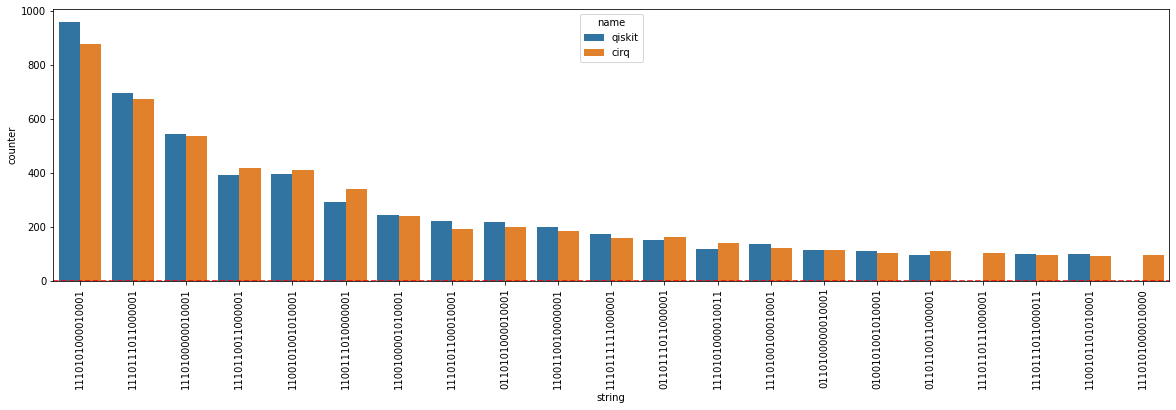

Program id: 5851
n_qubits: 15
n_shots: 8192.0
Uniform threshold: 0.25


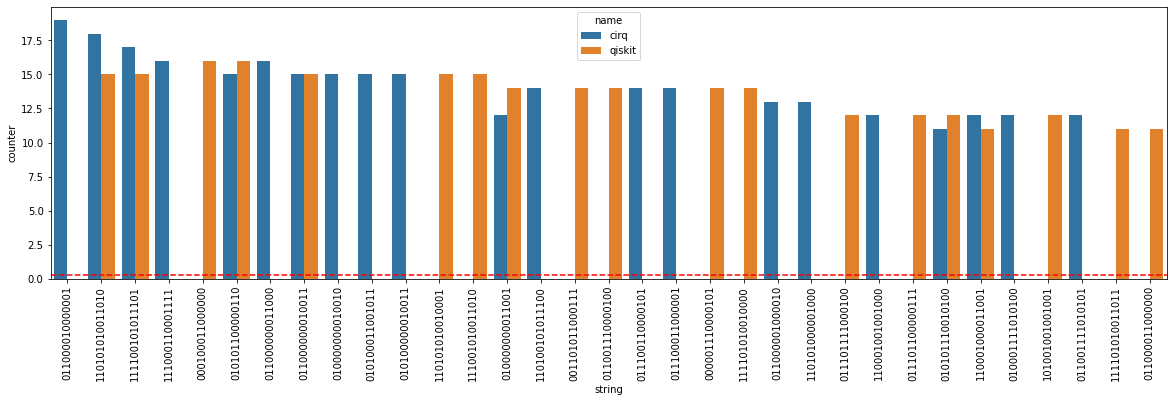

Program id: 217
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


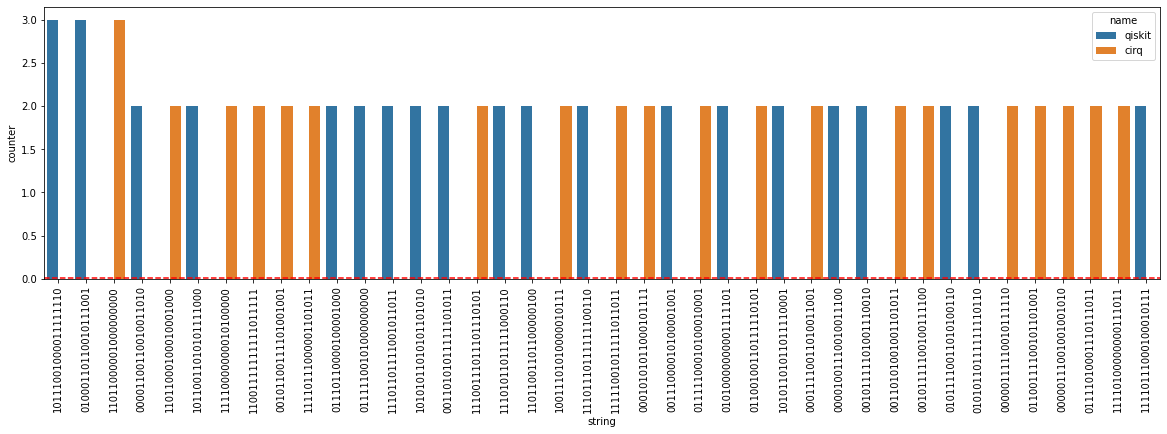

Program id: 7143
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


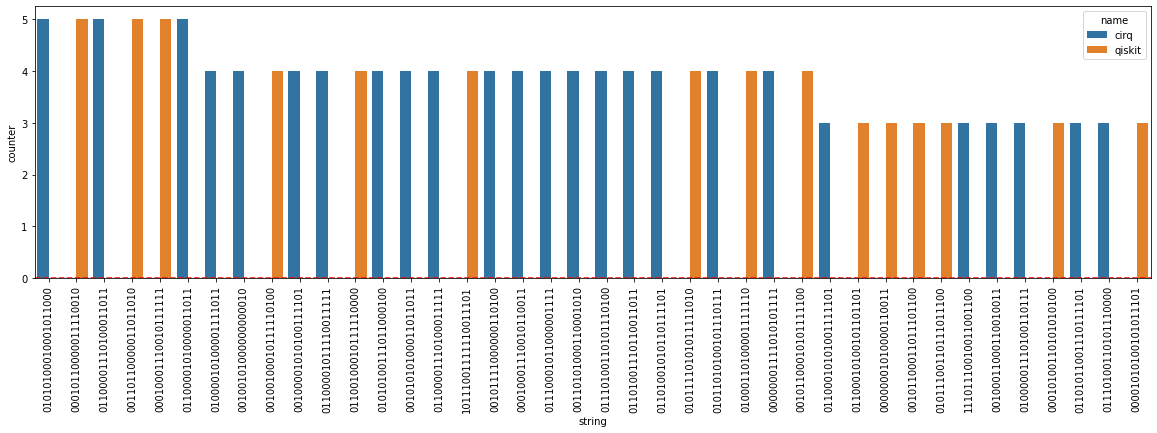

Program id: 6342
n_qubits: 14
n_shots: 8192.0
Uniform threshold: 0.5


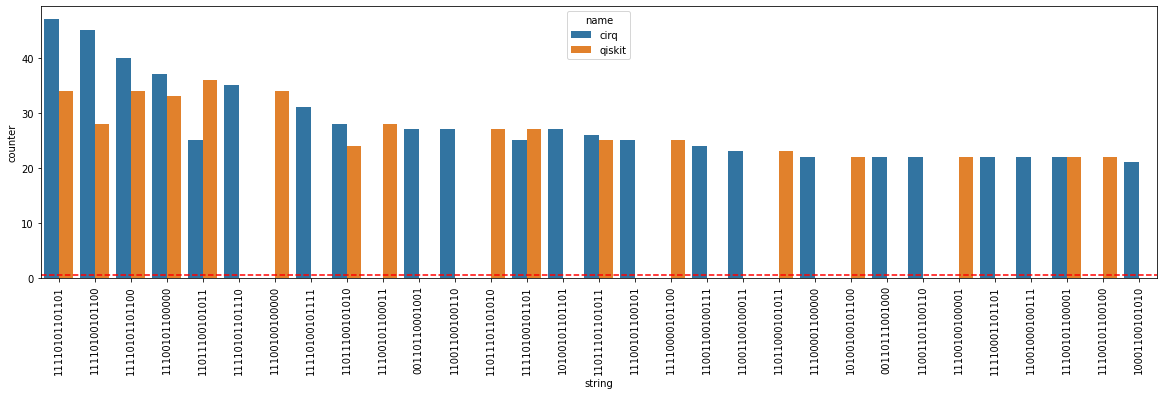

Program id: 6074
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


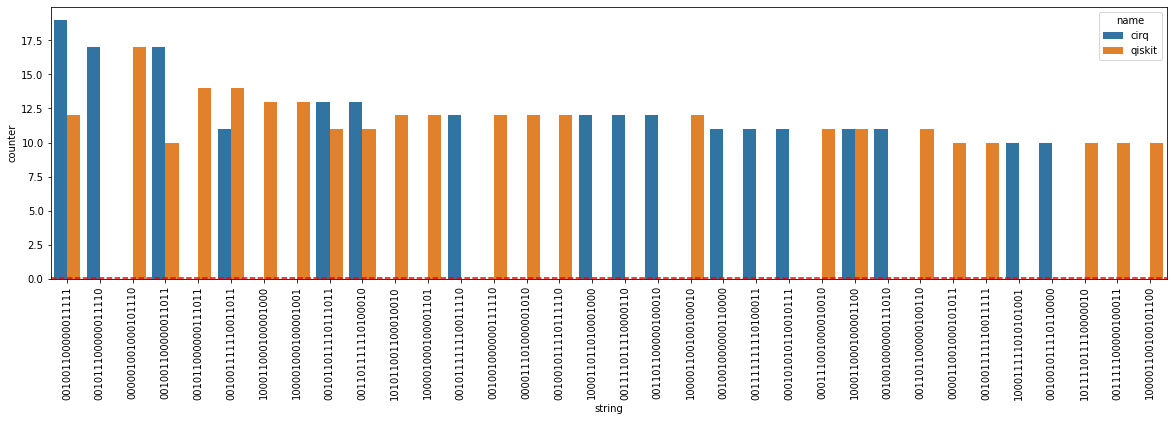

Program id: 5708
n_qubits: 16
n_shots: 8192.0
Uniform threshold: 0.125


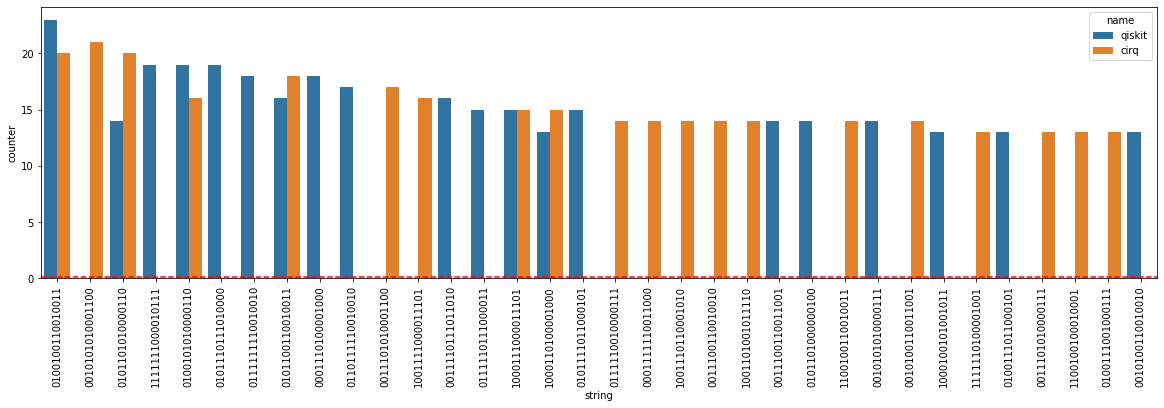

Program id: 801
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


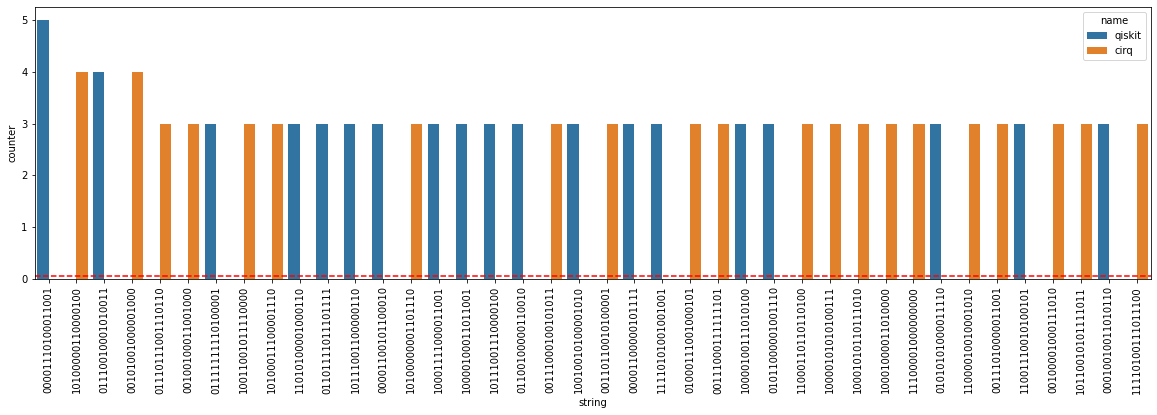

Program id: 6241
n_qubits: 16
n_shots: 8192.0
Uniform threshold: 0.125


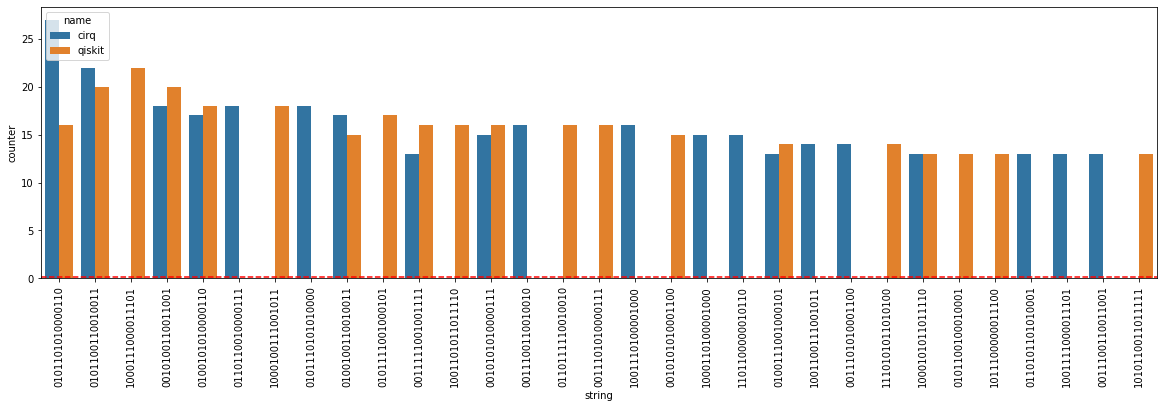

Program id: 8409
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


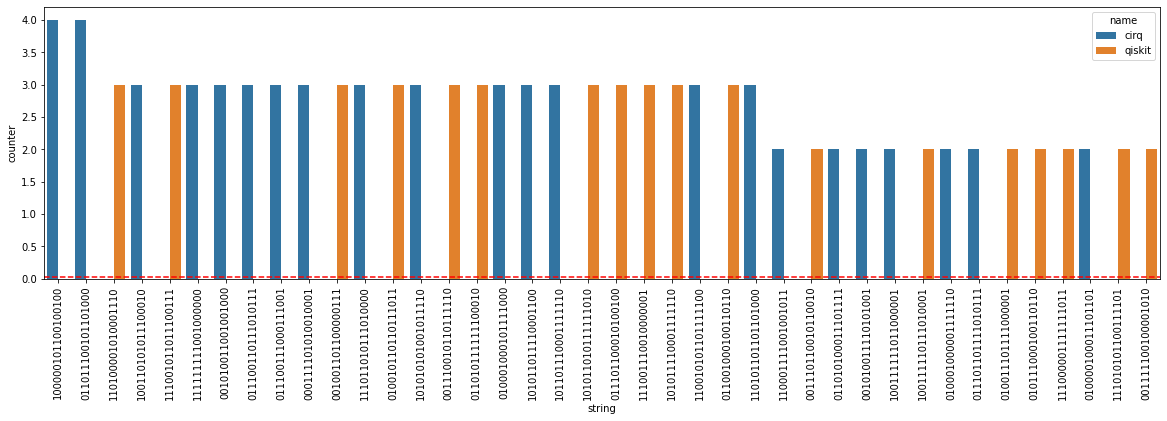

Program id: 7111
n_qubits: 15
n_shots: 8192.0
Uniform threshold: 0.25


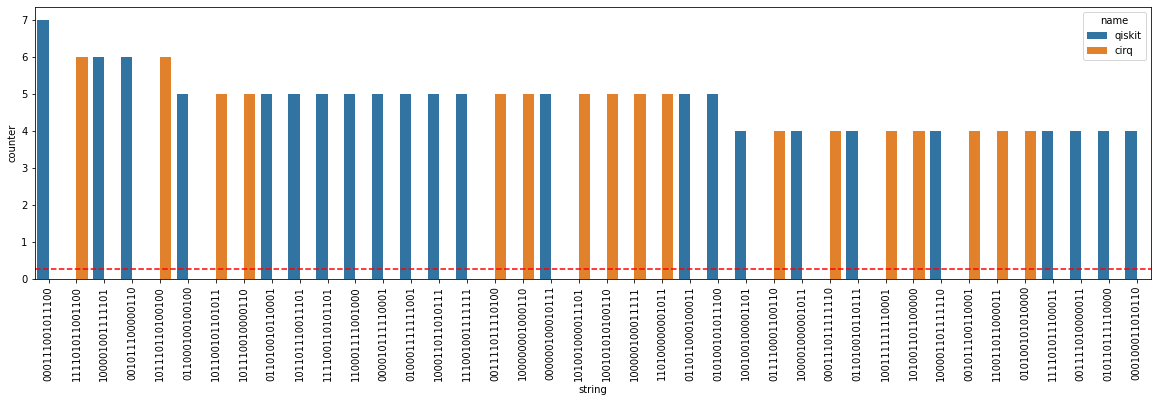

Program id: 451
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


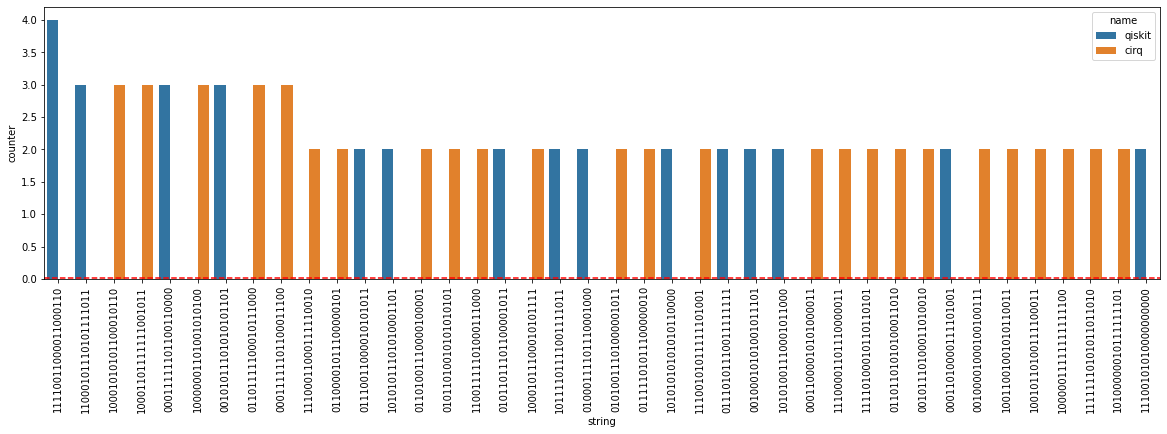

Program id: 5362
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


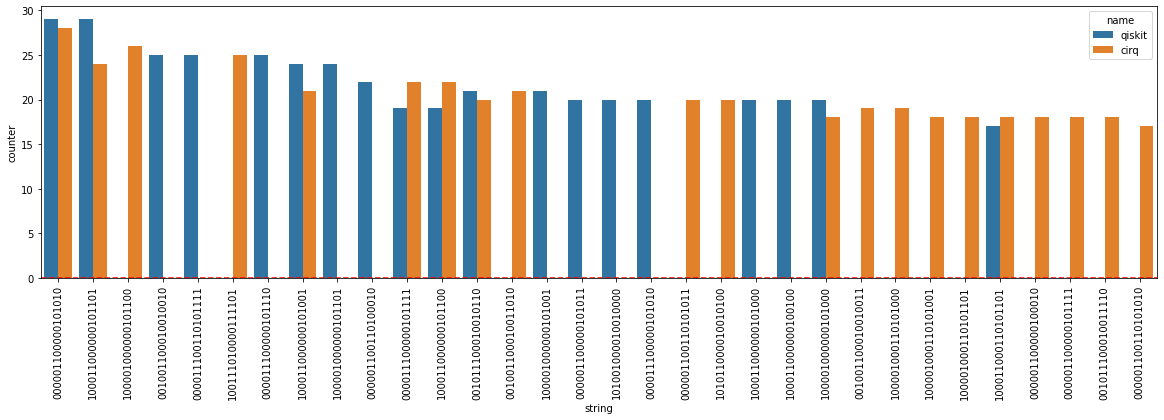

Program id: 9005
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


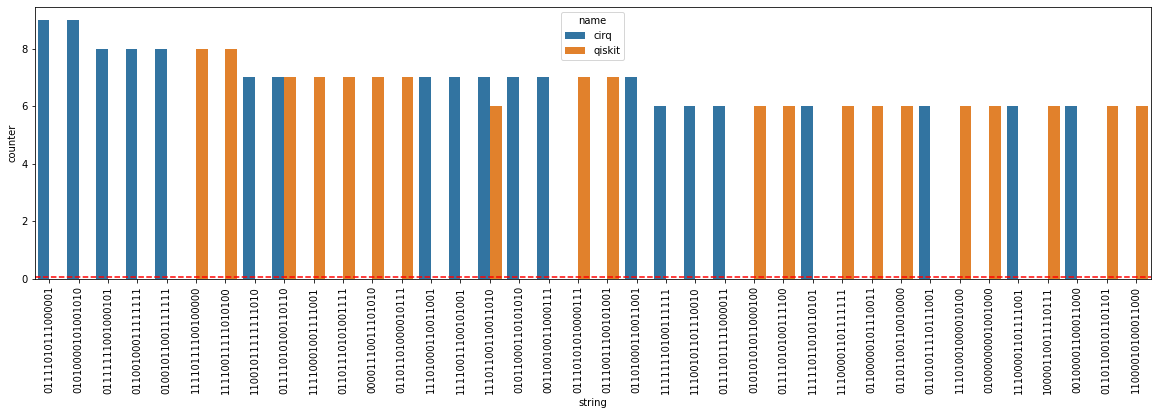

Program id: 7699
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


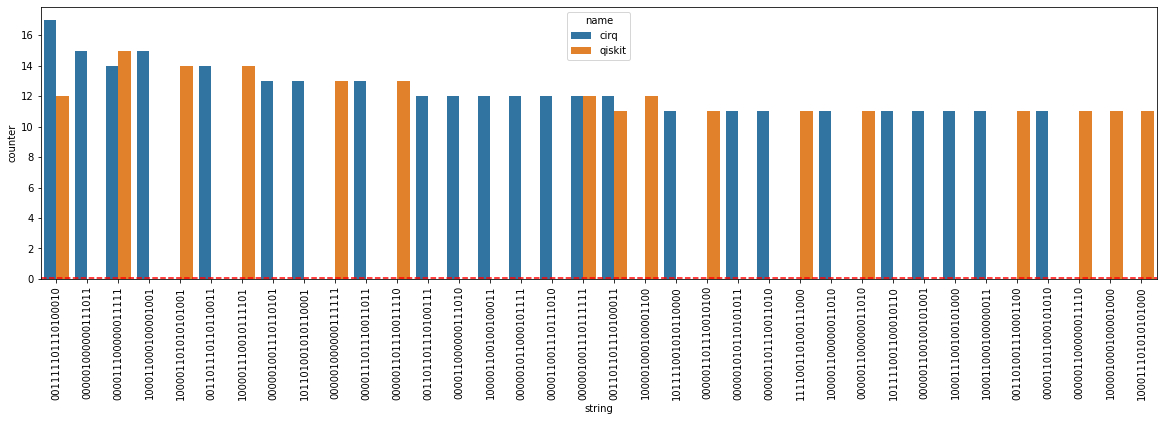

Program id: 9853
n_qubits: 19
n_shots: 8192.0
Uniform threshold: 0.015625


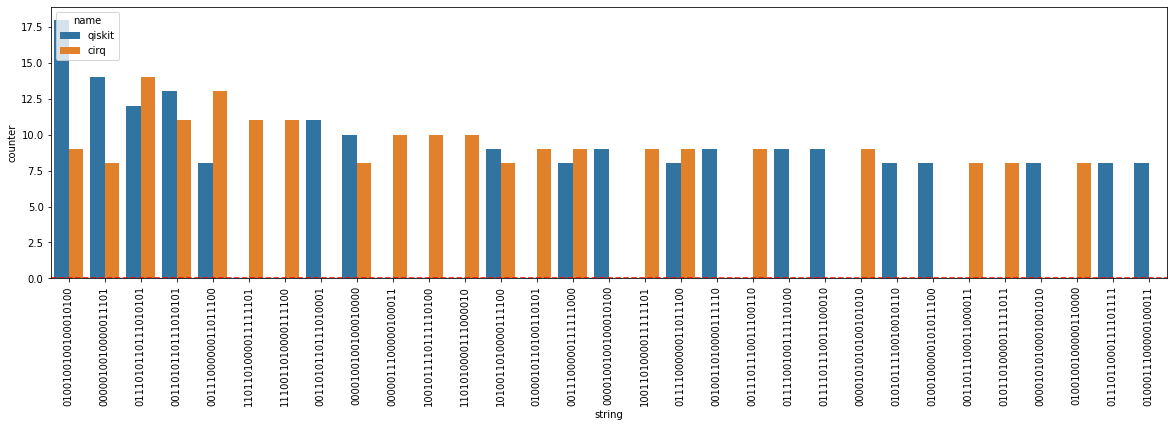

Program id: 2796
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


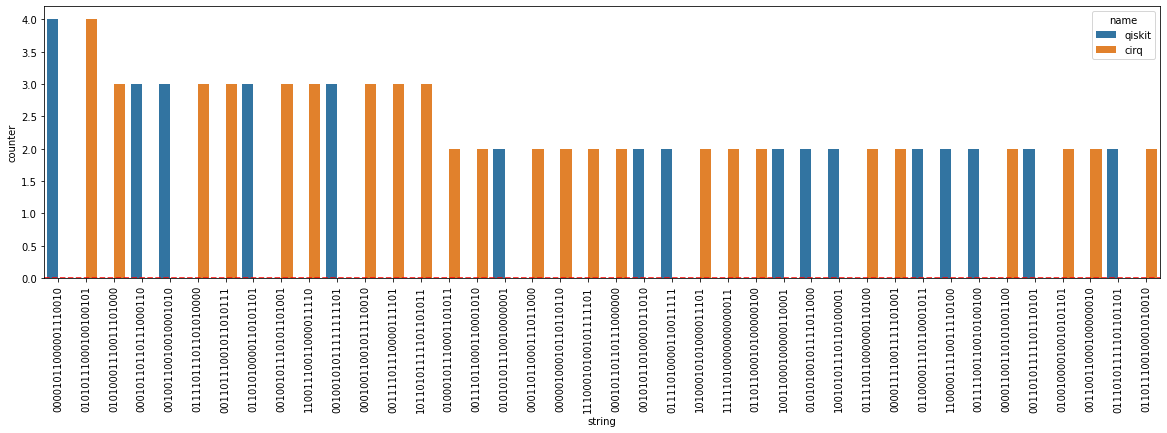

Program id: 168
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


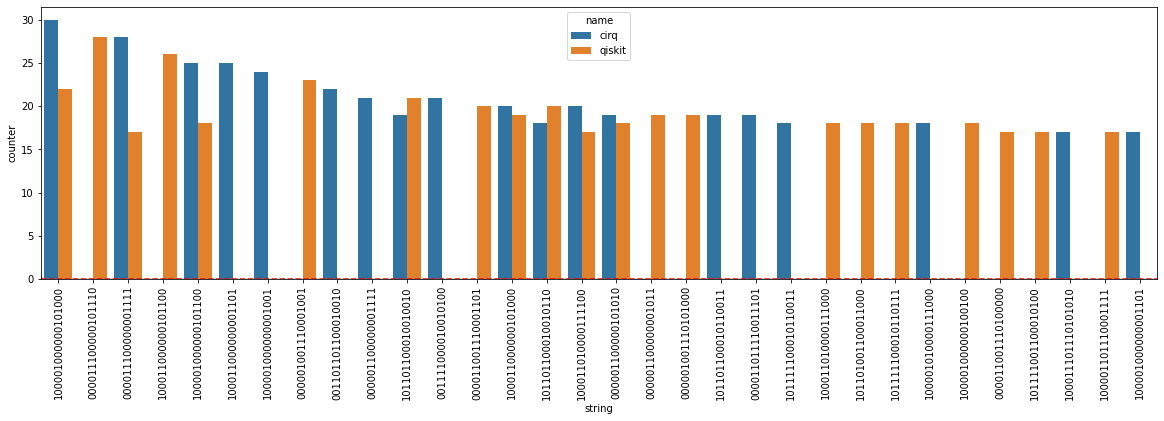

Program id: 1573
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


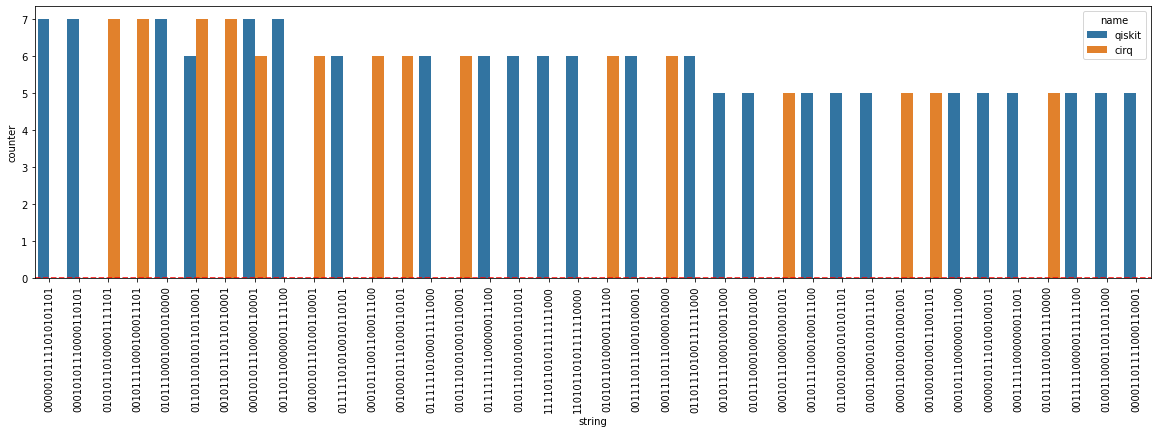

Program id: 7563
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


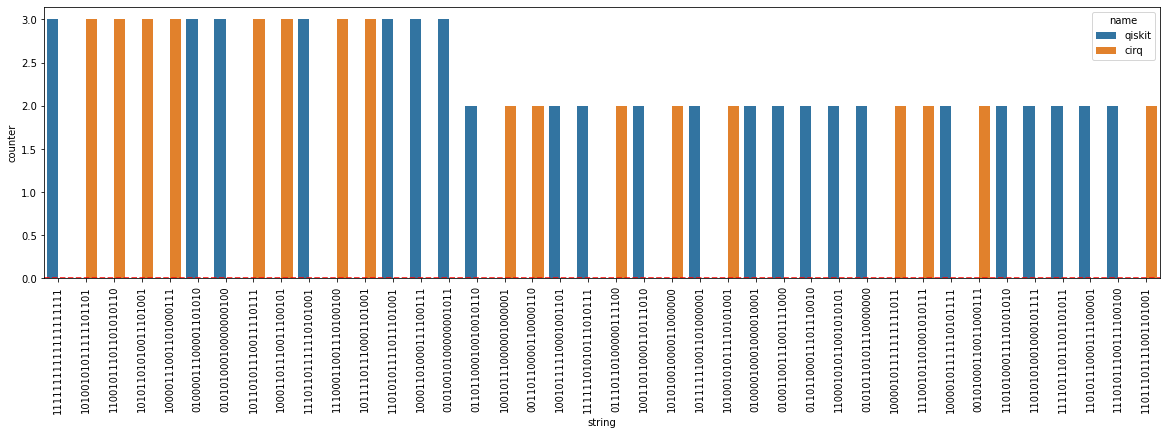

Program id: 3629
n_qubits: 12
n_shots: 8192.0
Uniform threshold: 2.0


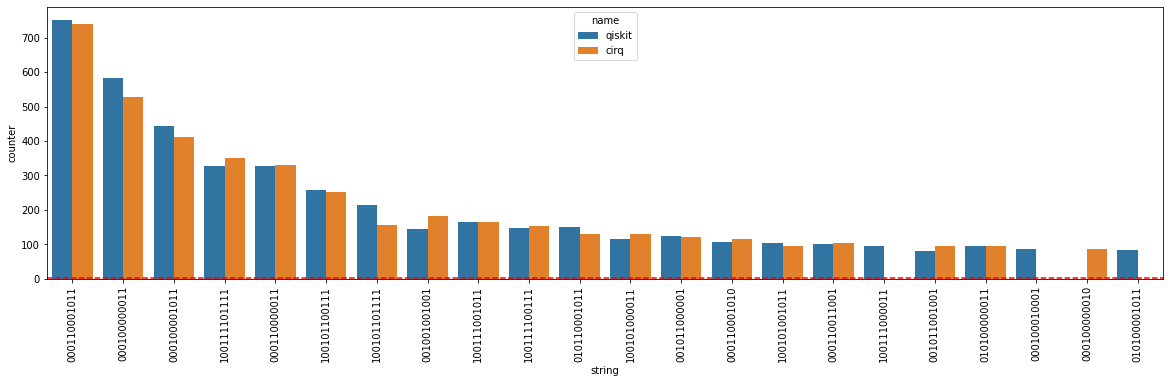

Program id: 4537
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


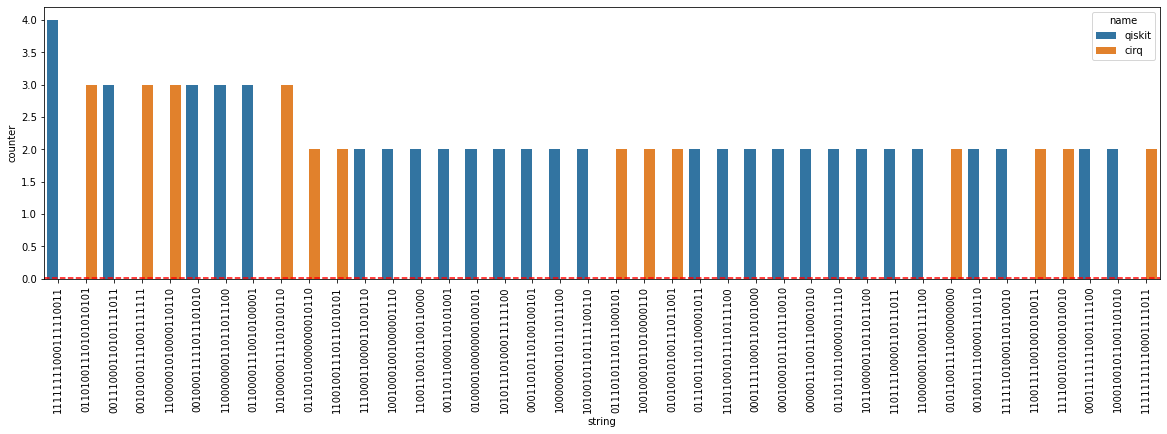

Program id: 4370
n_qubits: 4
n_shots: 8192.0
Uniform threshold: 512.0


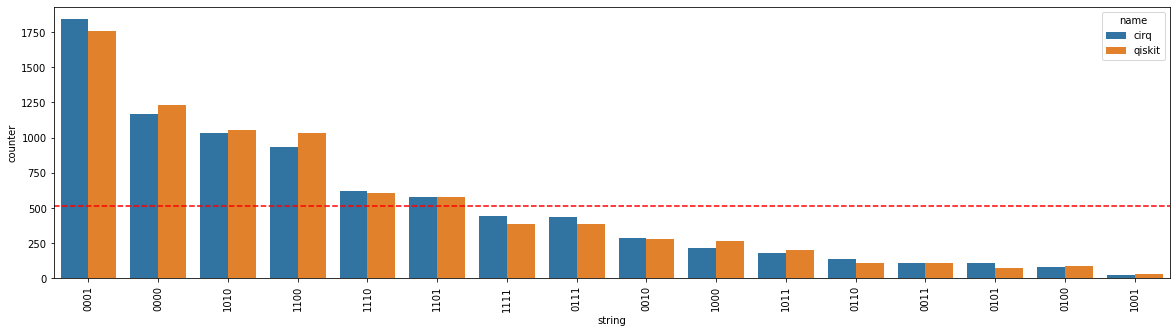

Program id: 7530
n_qubits: 14
n_shots: 8192.0
Uniform threshold: 0.5


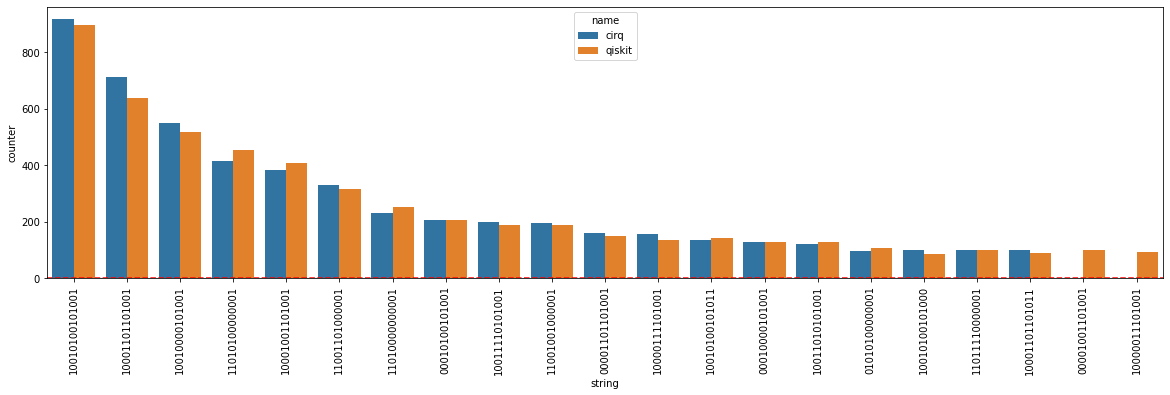

Program id: 2733
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


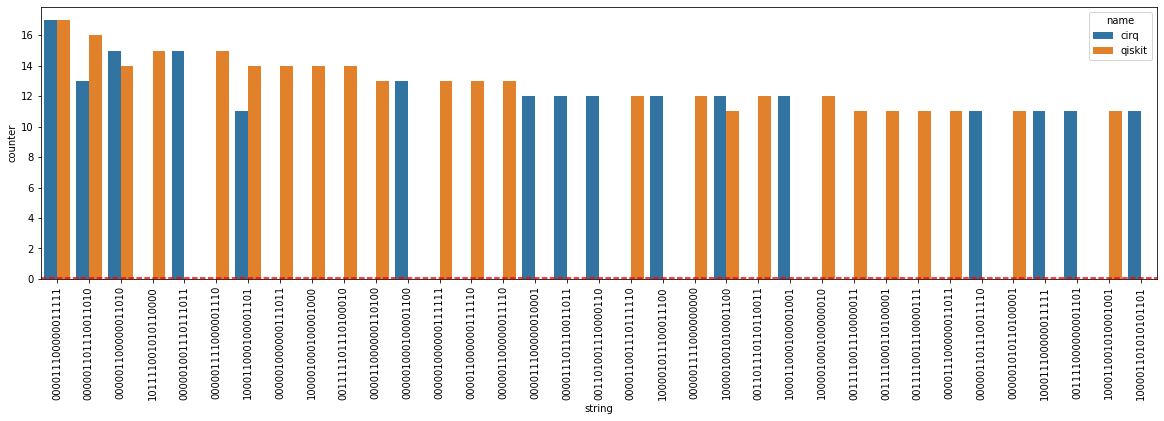

Program id: 8980
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


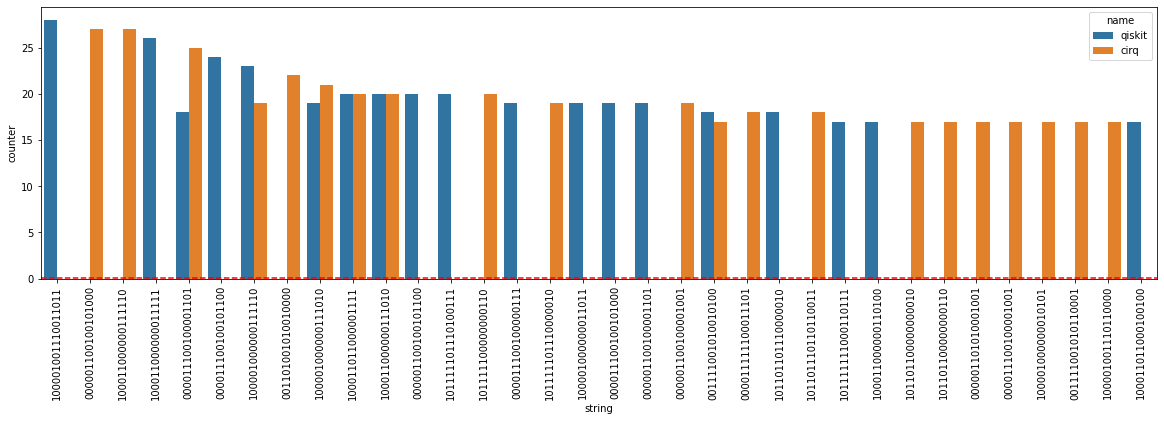

Program id: 4871
n_qubits: 5
n_shots: 8192.0
Uniform threshold: 256.0


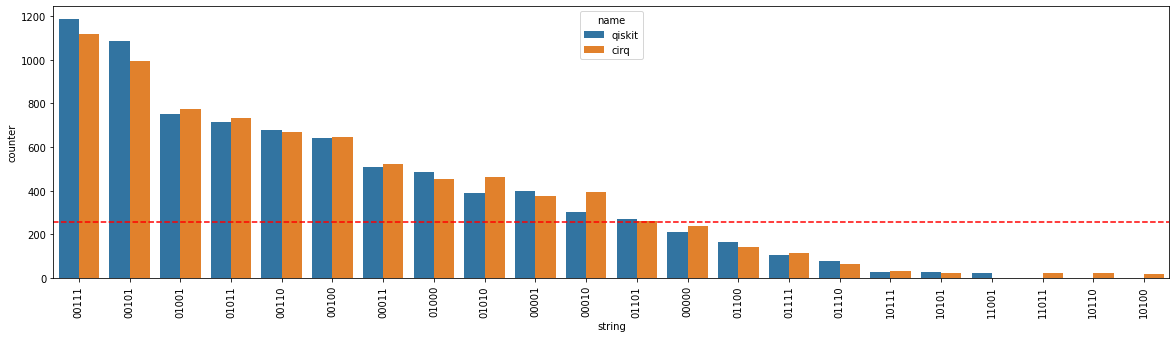

Program id: 5434
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


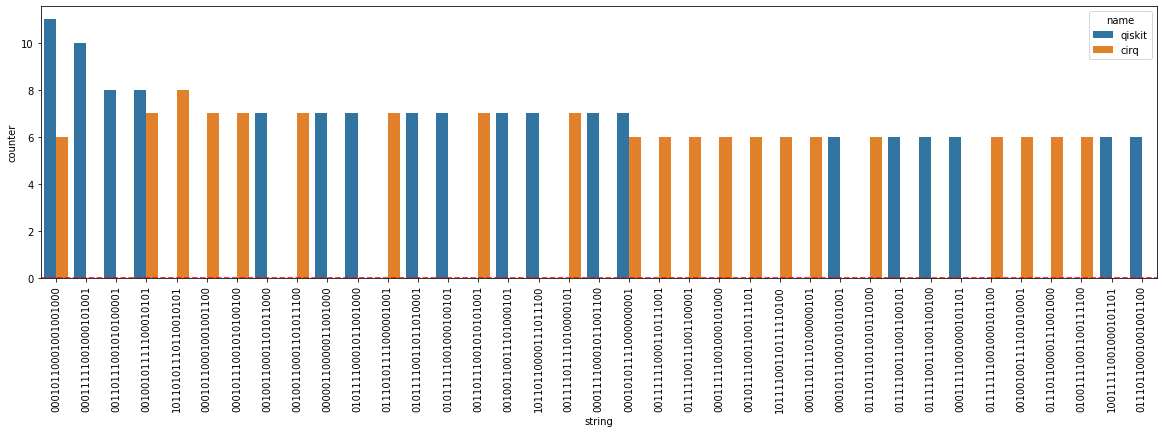

Program id: 7797
n_qubits: 19
n_shots: 8192.0
Uniform threshold: 0.015625


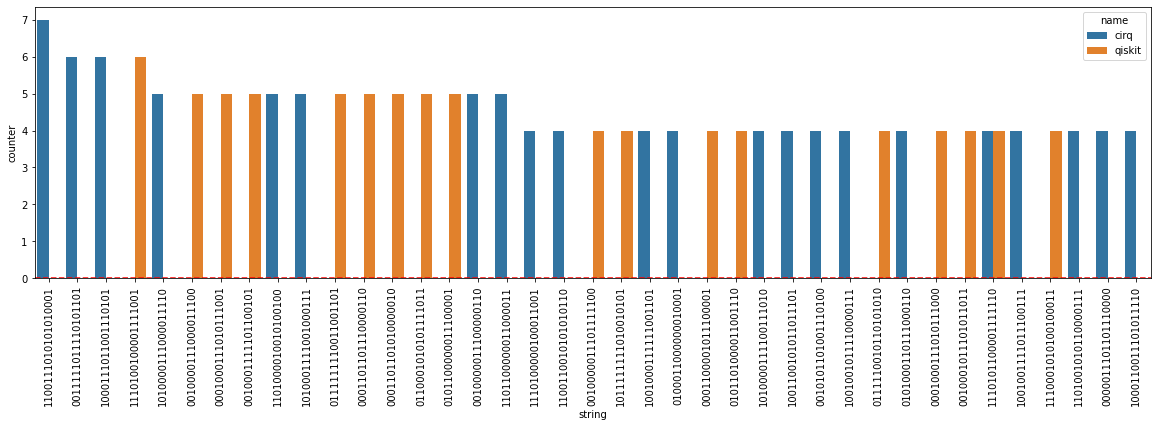

Program id: 5989
n_qubits: 11
n_shots: 8192.0
Uniform threshold: 4.0


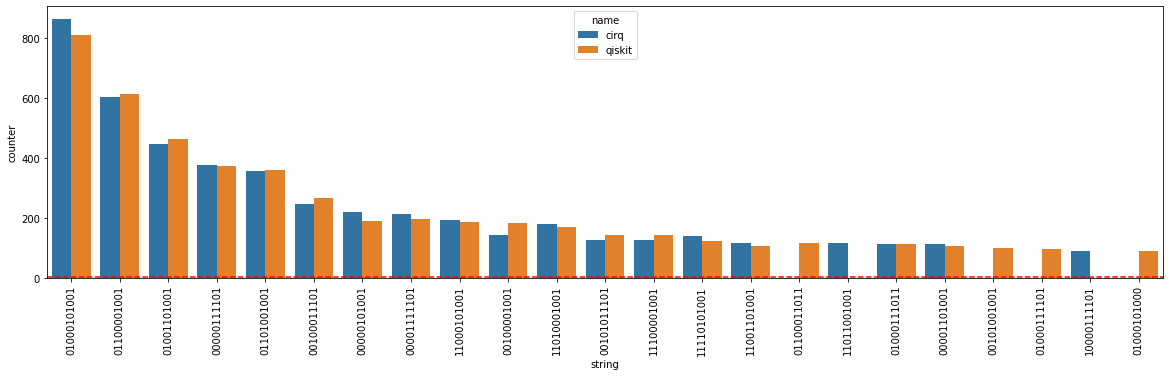

Program id: 3451
n_qubits: 6
n_shots: 8192.0
Uniform threshold: 128.0


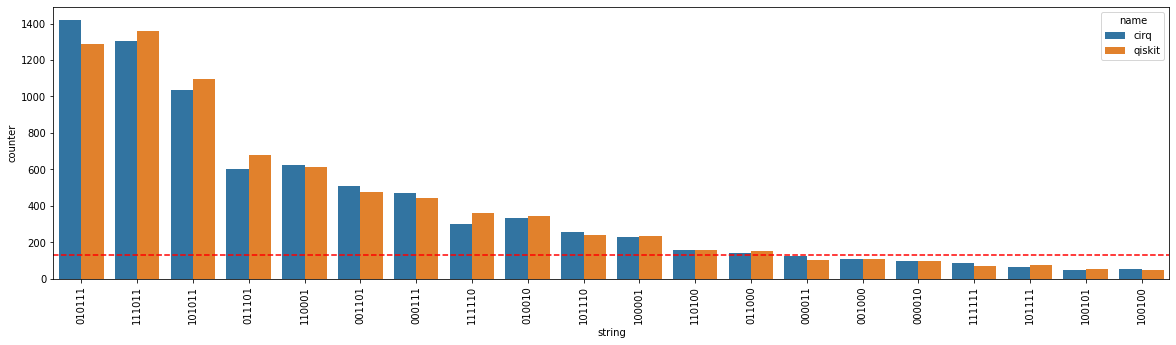

Program id: 1131
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


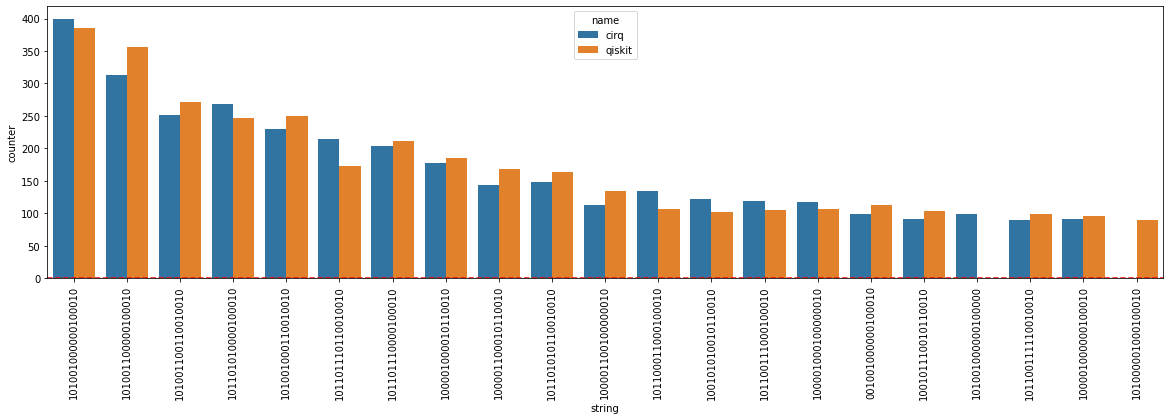

Program id: 5953
n_qubits: 19
n_shots: 8192.0
Uniform threshold: 0.015625


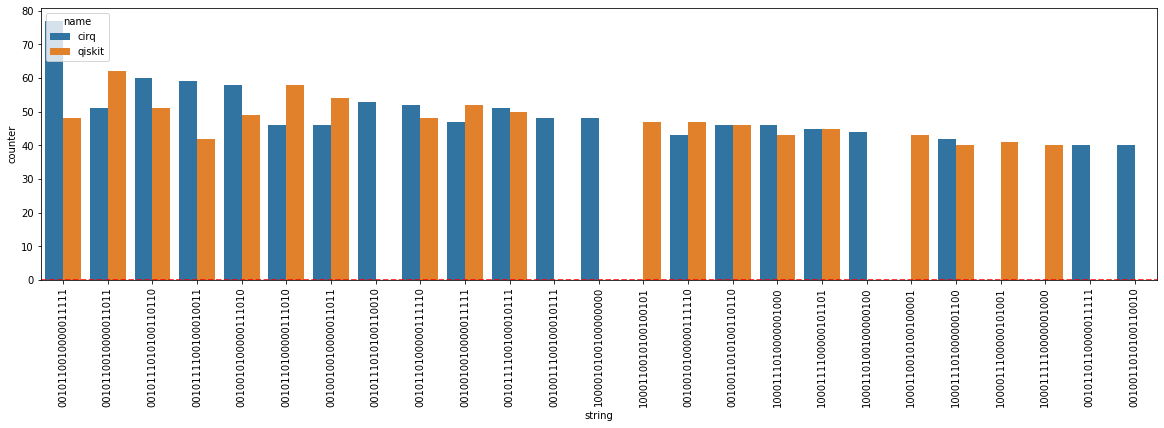

Program id: 4604
n_qubits: 16
n_shots: 8192.0
Uniform threshold: 0.125


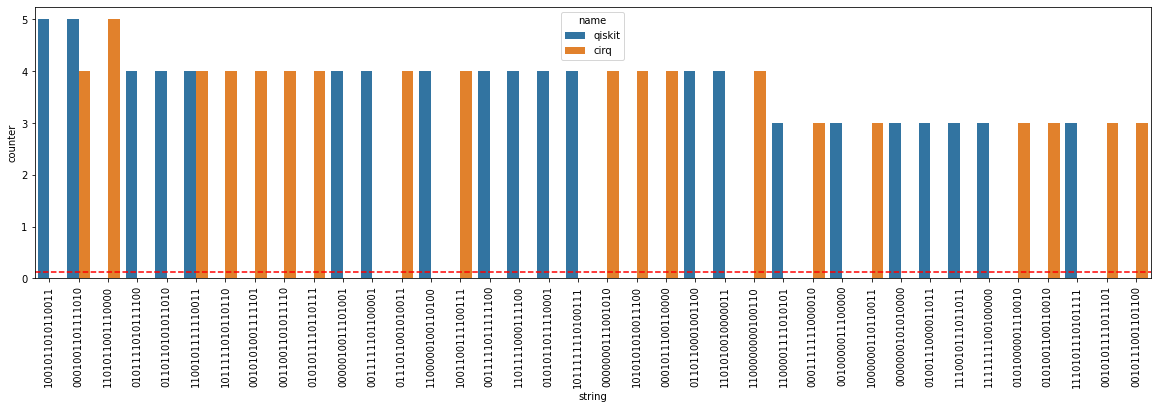

Program id: 2065
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


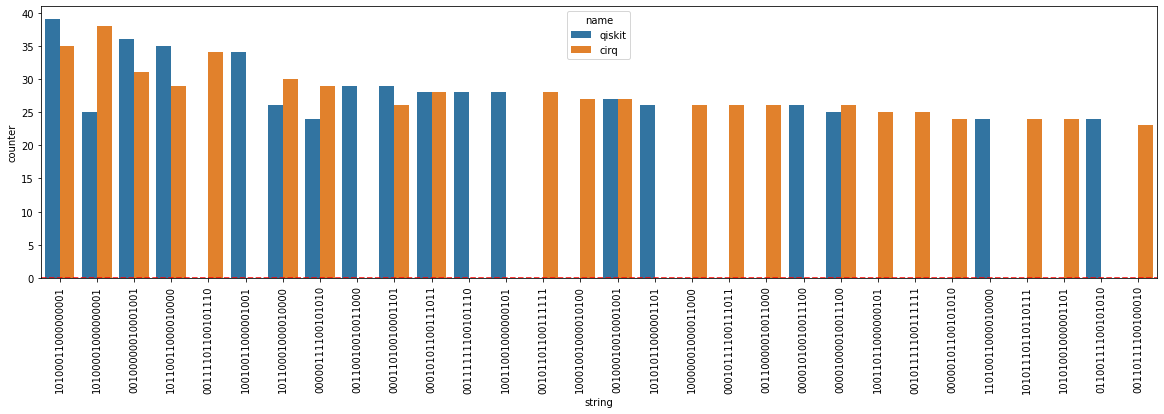

Program id: 4423
n_qubits: 14
n_shots: 8192.0
Uniform threshold: 0.5


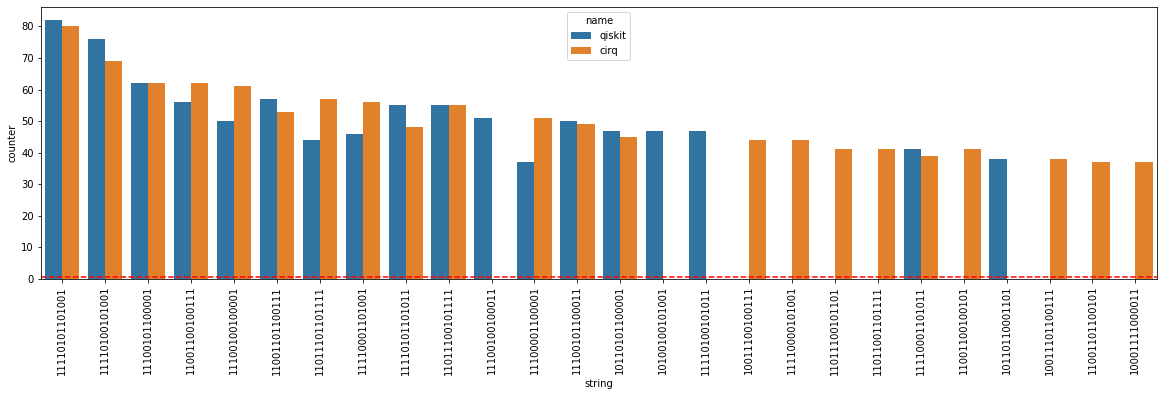

Program id: 2506
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


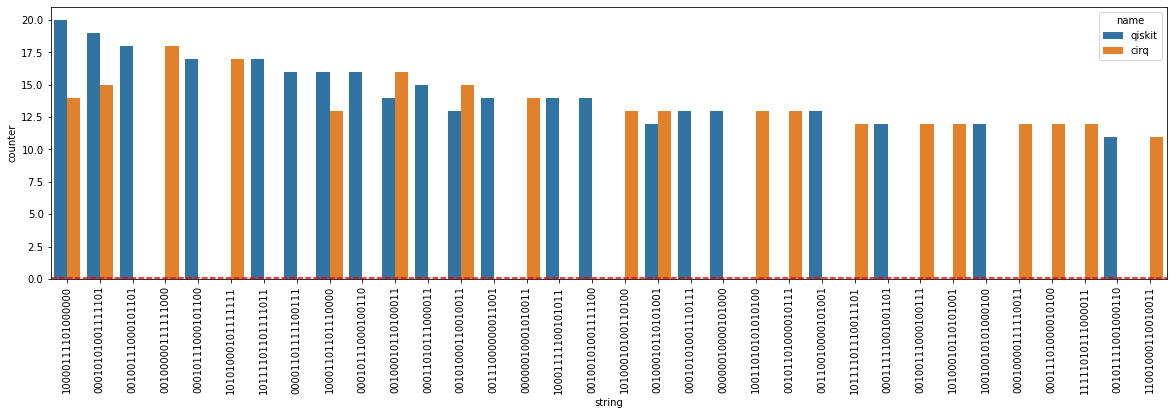

Program id: 1627
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


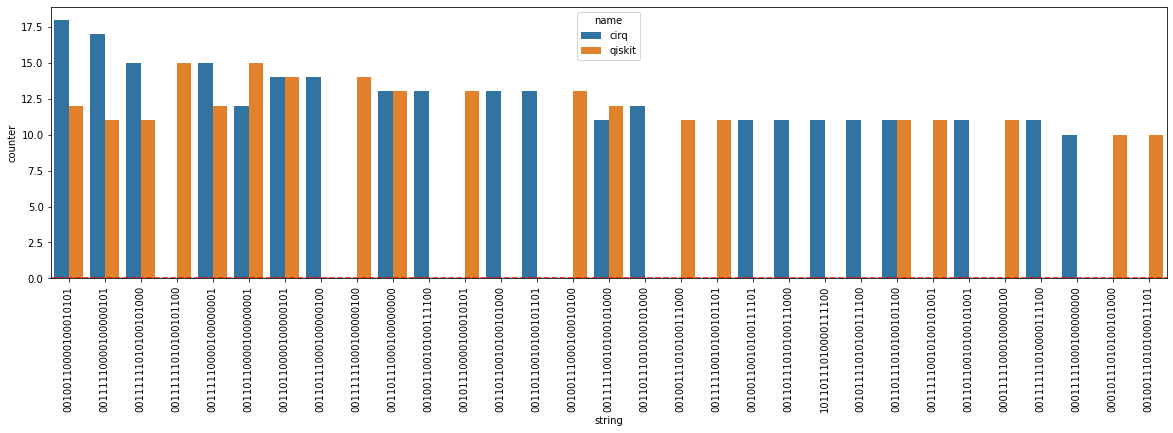

Program id: 6470
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


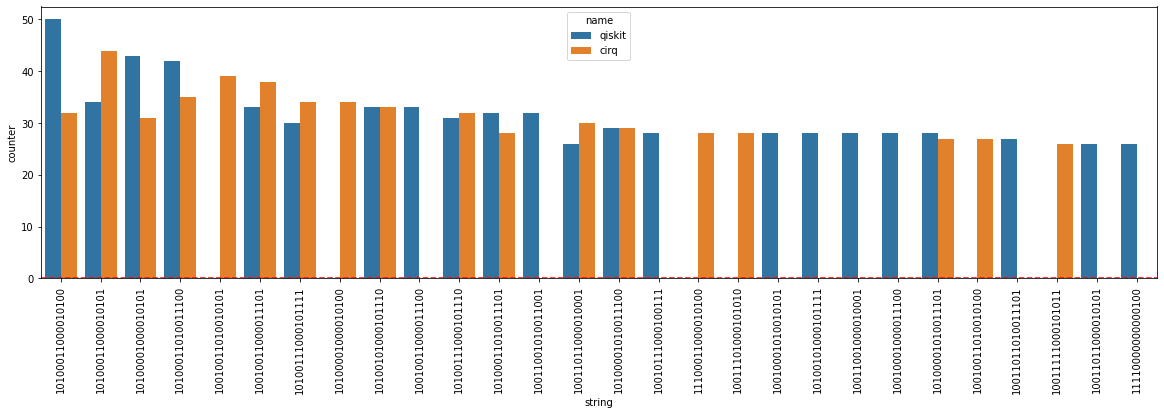

Program id: 9563
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


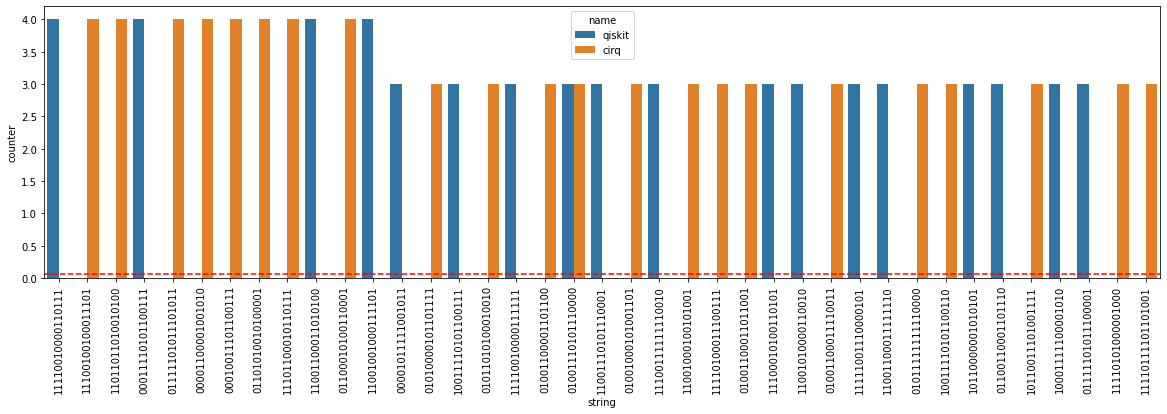

Program id: 9055
n_qubits: 15
n_shots: 8192.0
Uniform threshold: 0.25


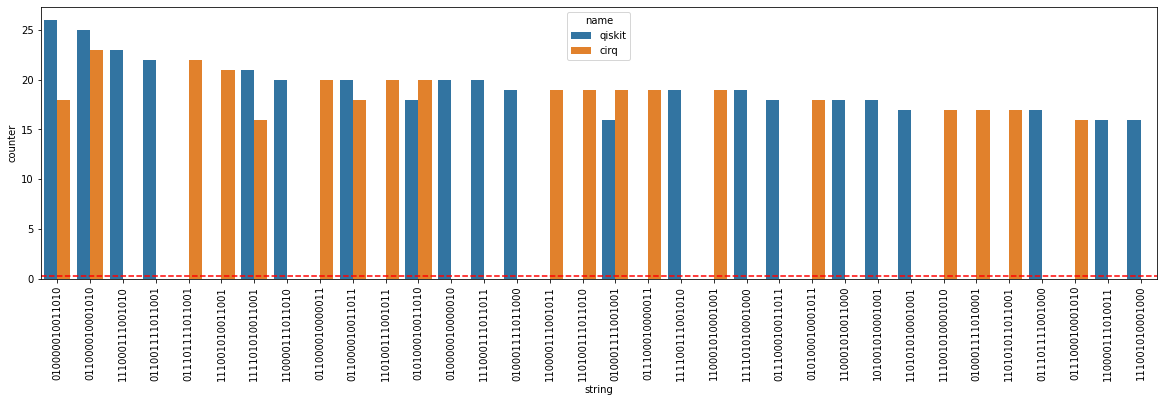

Program id: 7591
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


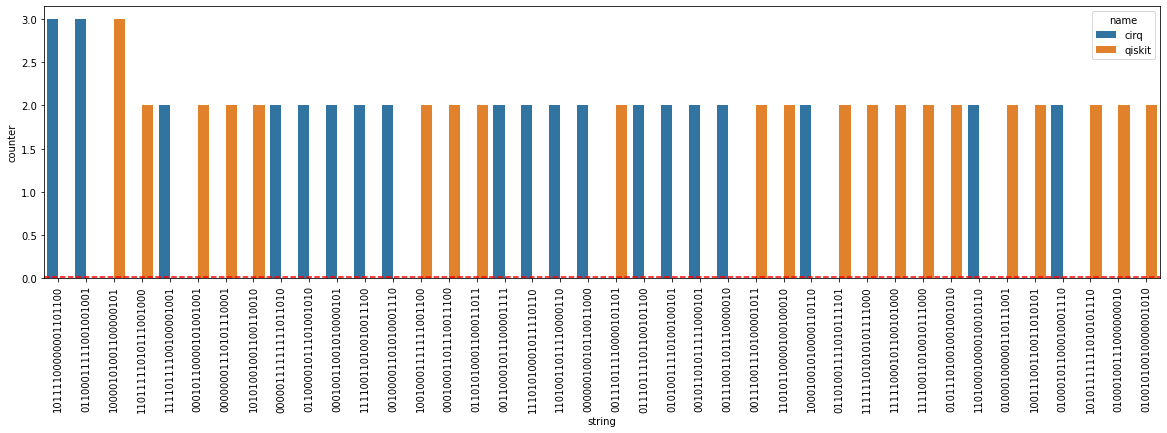

Program id: 3265
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


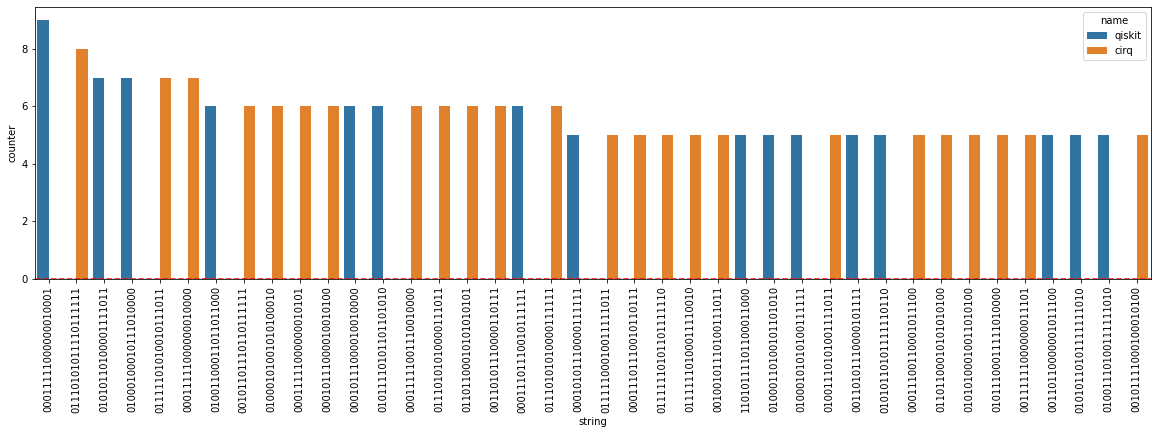

Program id: 8908
n_qubits: 19
n_shots: 8192.0
Uniform threshold: 0.015625


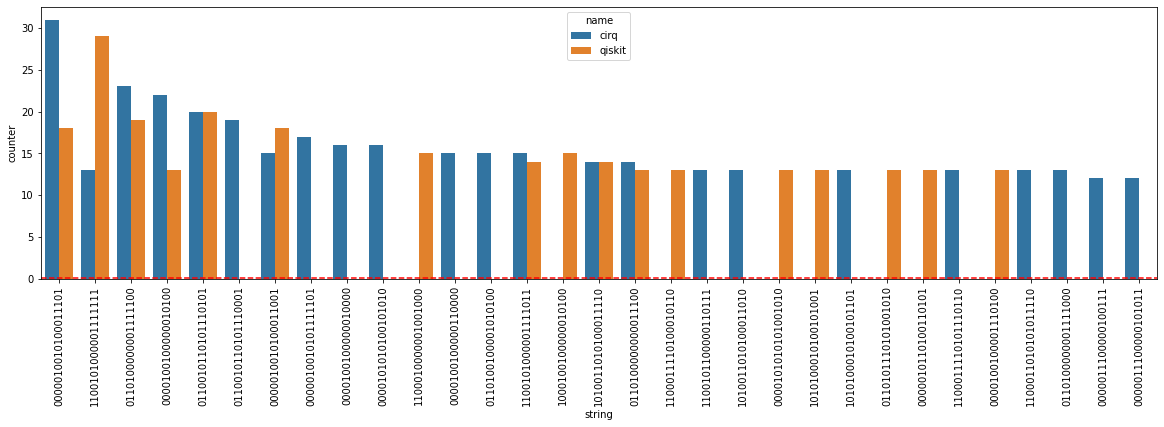

Program id: 9872
n_qubits: 6
n_shots: 8192.0
Uniform threshold: 128.0


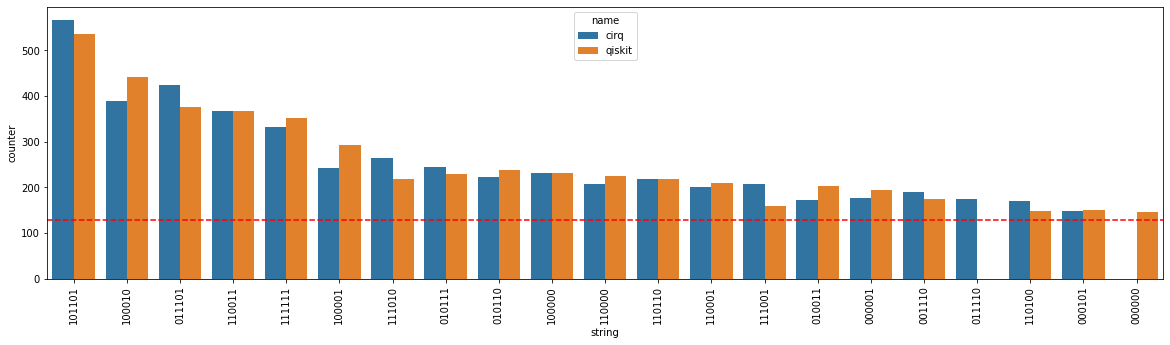

Program id: 6616
n_qubits: 19
n_shots: 8192.0
Uniform threshold: 0.015625


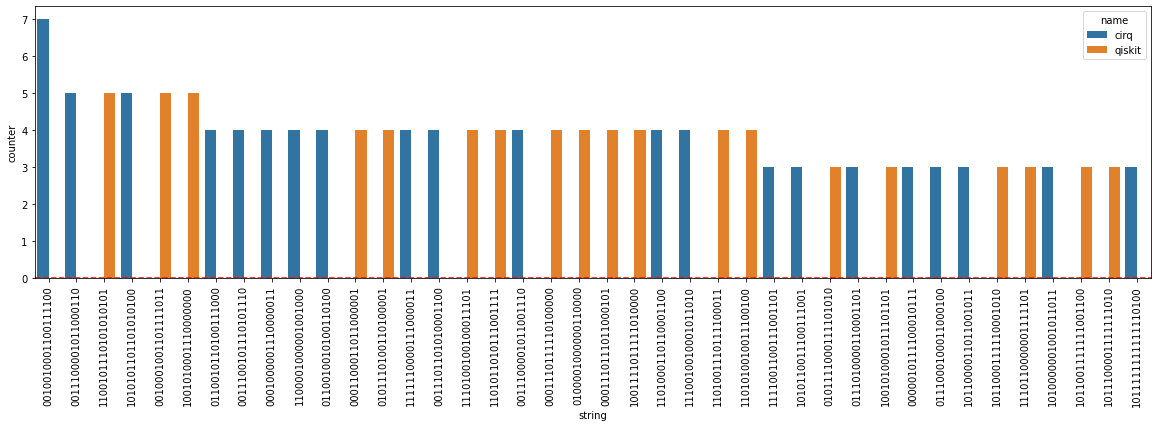

Program id: 8239
n_qubits: 4
n_shots: 8192.0
Uniform threshold: 512.0


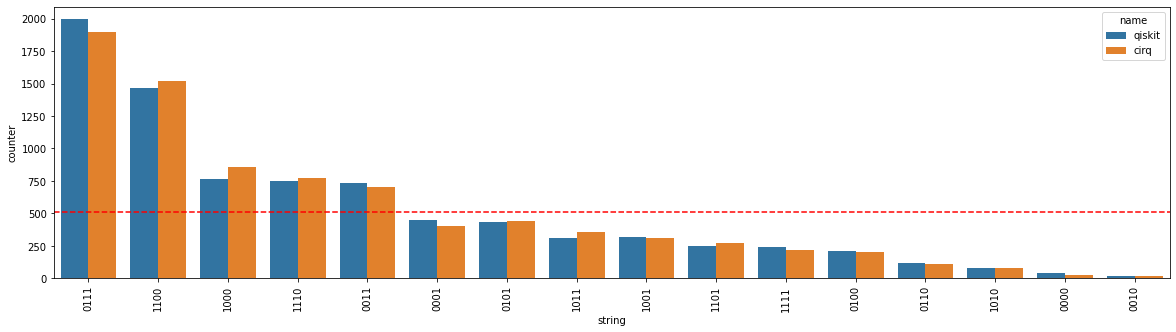

Program id: 8112
n_qubits: 15
n_shots: 8192.0
Uniform threshold: 0.25


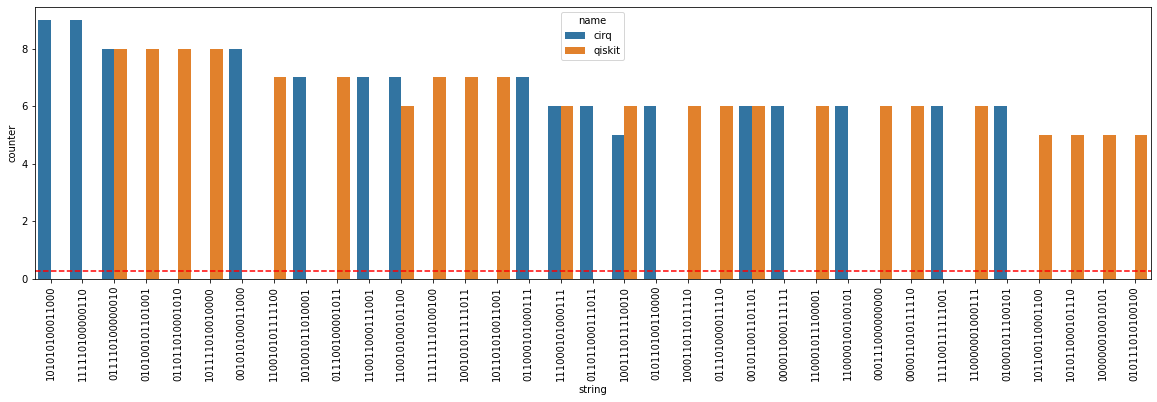

Program id: 3355
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


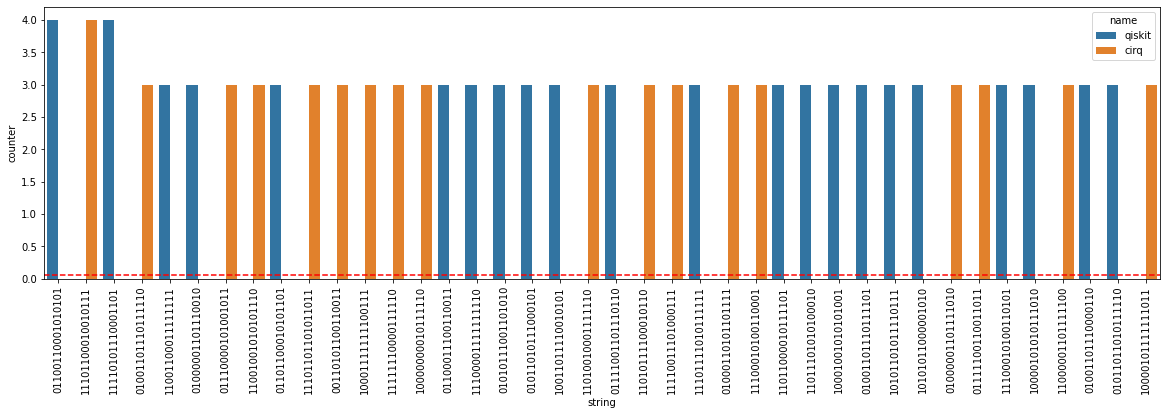

Program id: 8488
n_qubits: 16
n_shots: 8192.0
Uniform threshold: 0.125


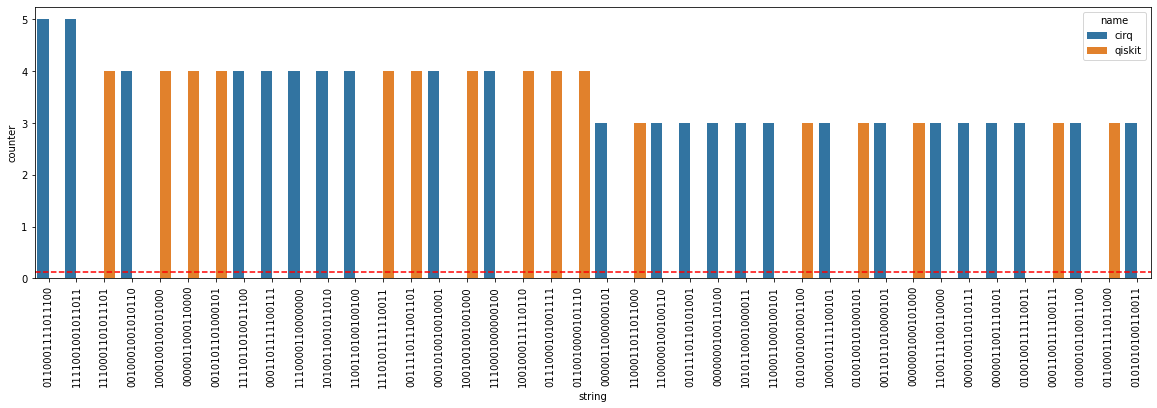

Program id: 2028
n_qubits: 4
n_shots: 8192.0
Uniform threshold: 512.0


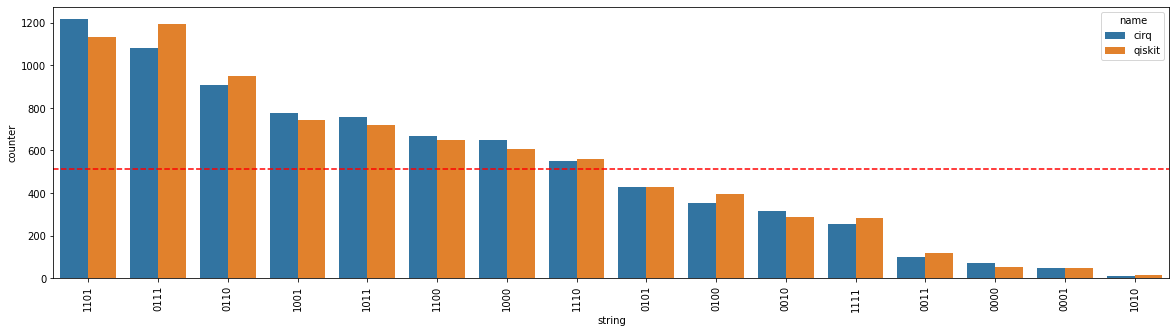

Program id: 1866
n_qubits: 13
n_shots: 8192.0
Uniform threshold: 1.0


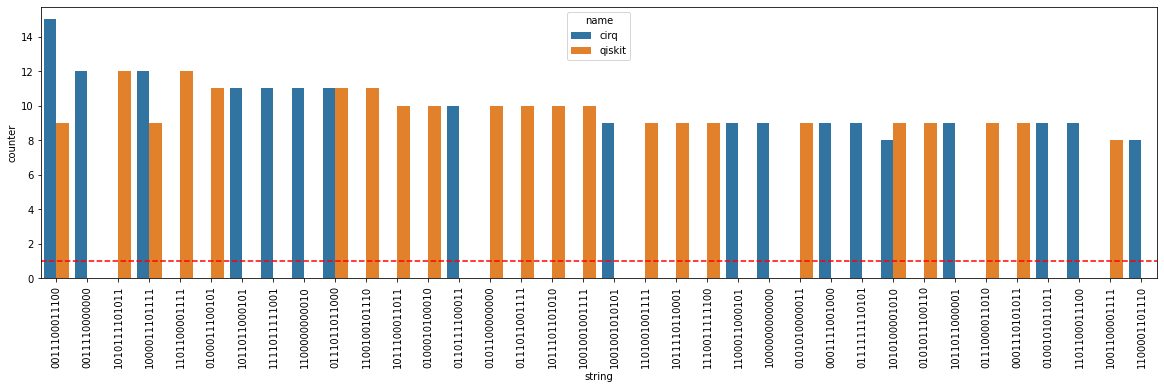

Program id: 6359
n_qubits: 13
n_shots: 8192.0
Uniform threshold: 1.0


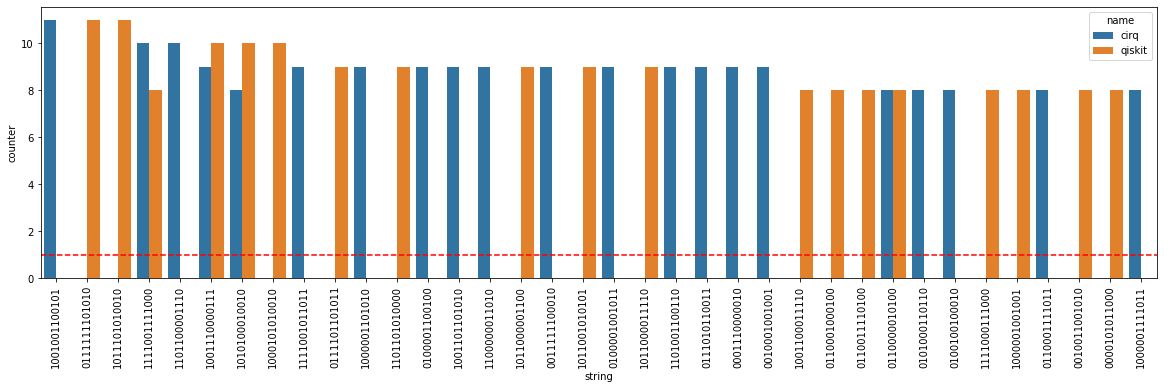

Program id: 5765
n_qubits: 14
n_shots: 8192.0
Uniform threshold: 0.5


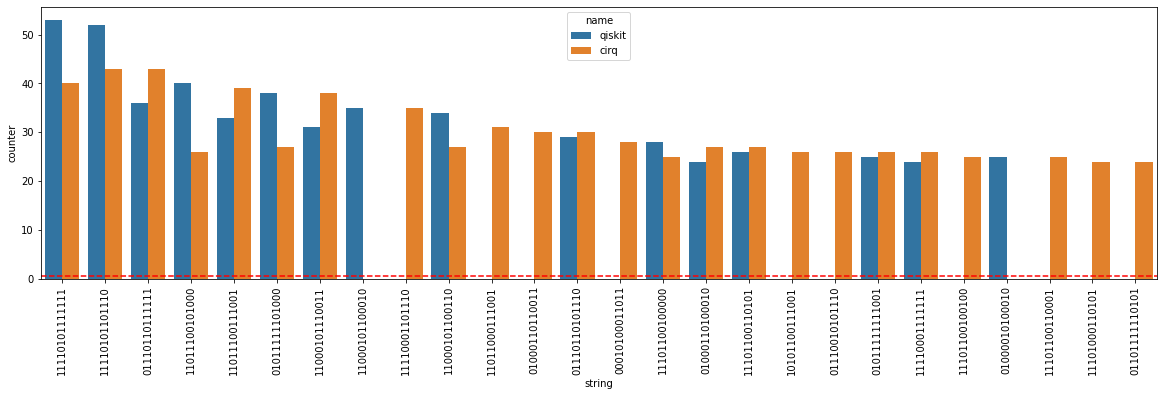

Program id: 8827
n_qubits: 19
n_shots: 8192.0
Uniform threshold: 0.015625


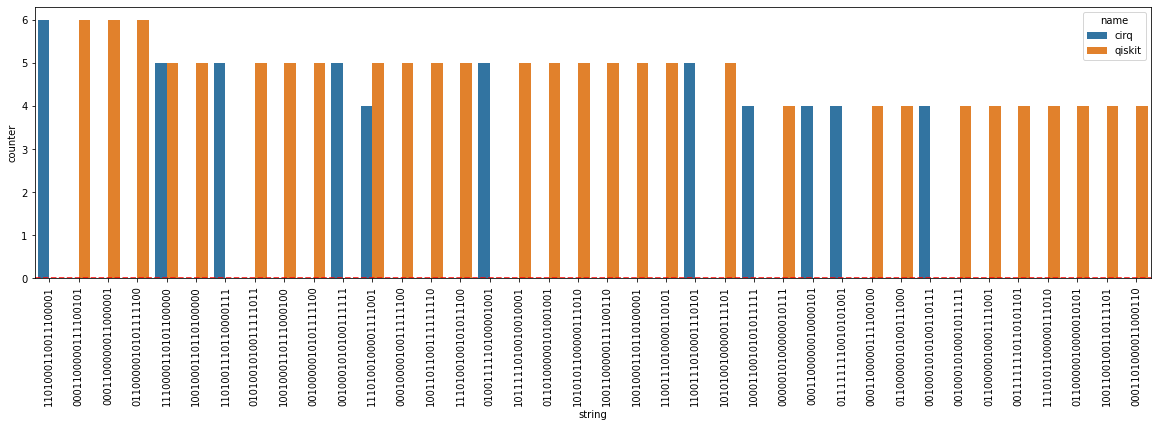

Program id: 7574
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


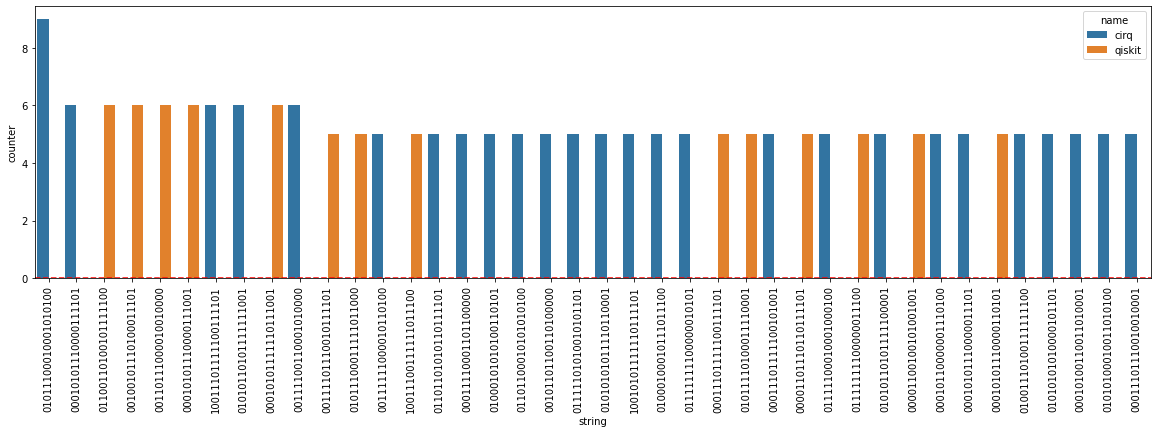

Program id: 3000
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


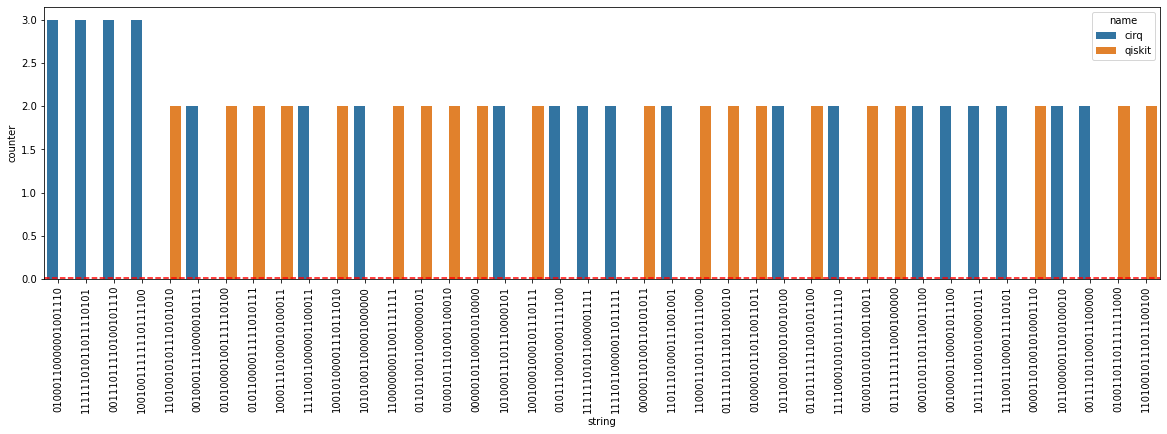

Program id: 1602
n_qubits: 14
n_shots: 8192.0
Uniform threshold: 0.5


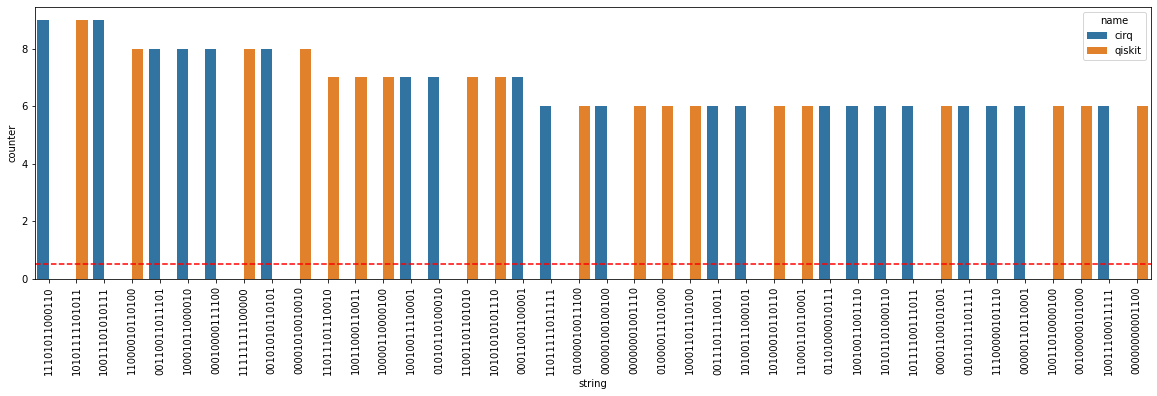

Program id: 6028
n_qubits: 19
n_shots: 8192.0
Uniform threshold: 0.015625


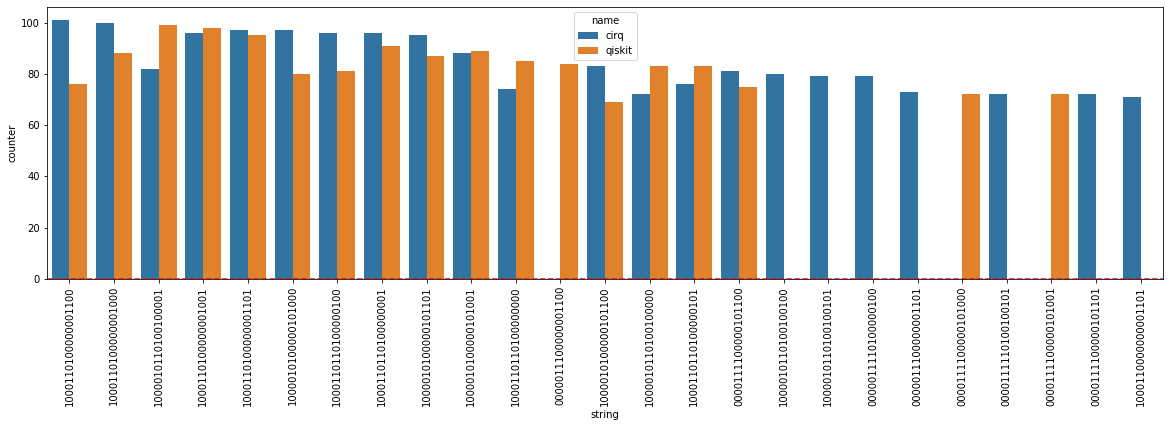

Program id: 2405
n_qubits: 15
n_shots: 8192.0
Uniform threshold: 0.25


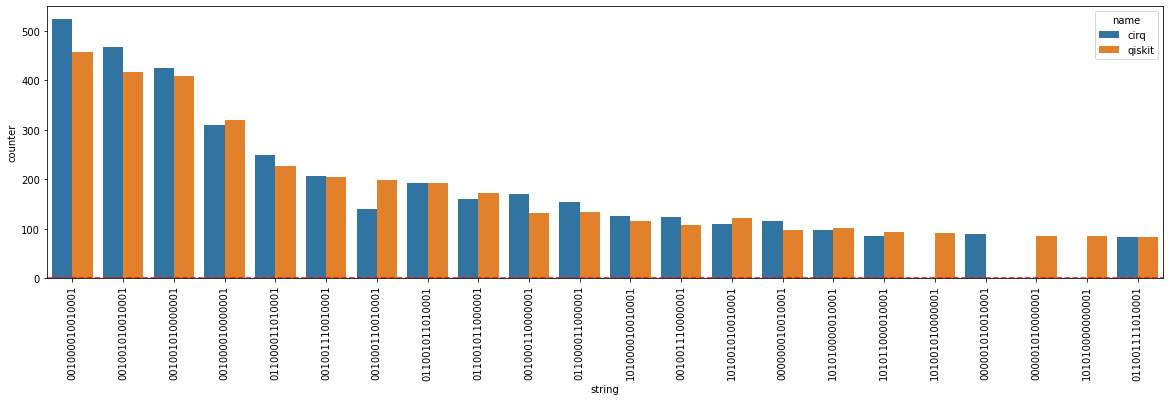

Program id: 3545
n_qubits: 11
n_shots: 8192.0
Uniform threshold: 4.0


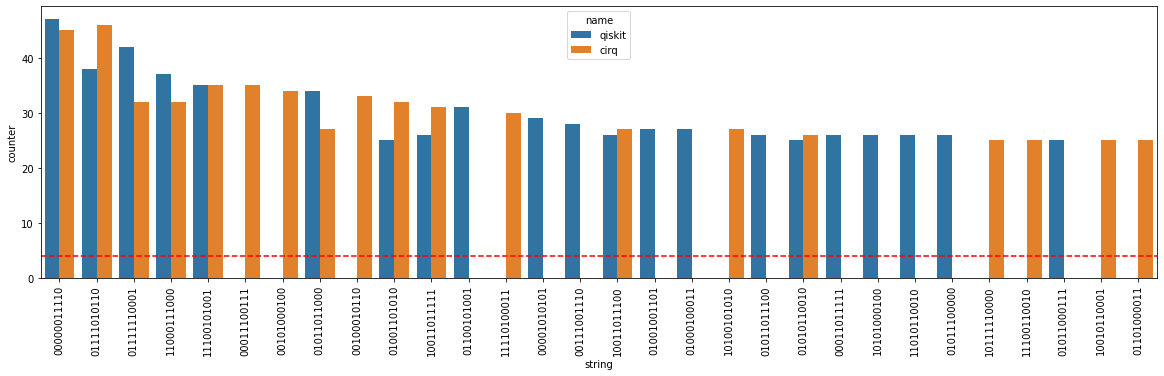

Program id: 7625
n_qubits: 2
n_shots: 8192.0
Uniform threshold: 2048.0


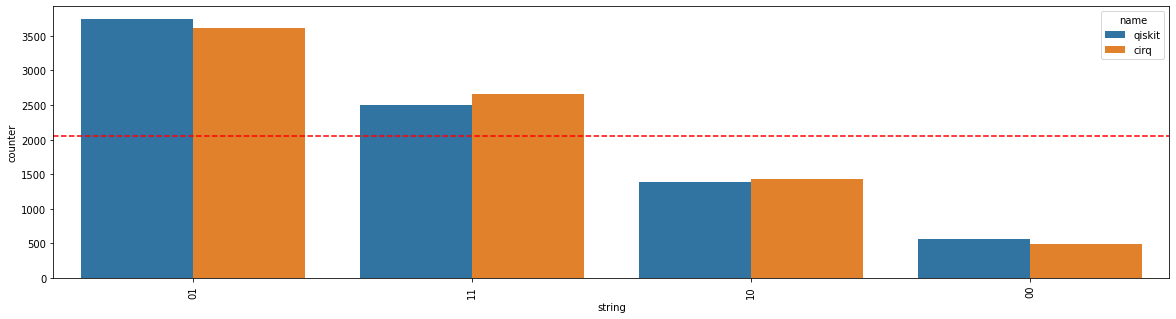

Program id: 6893
n_qubits: 15
n_shots: 8192.0
Uniform threshold: 0.25


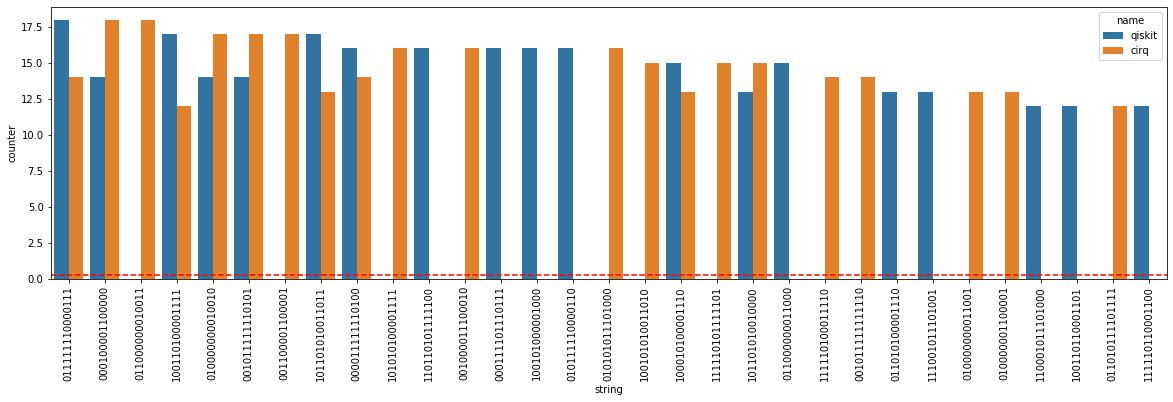

Program id: 3383
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


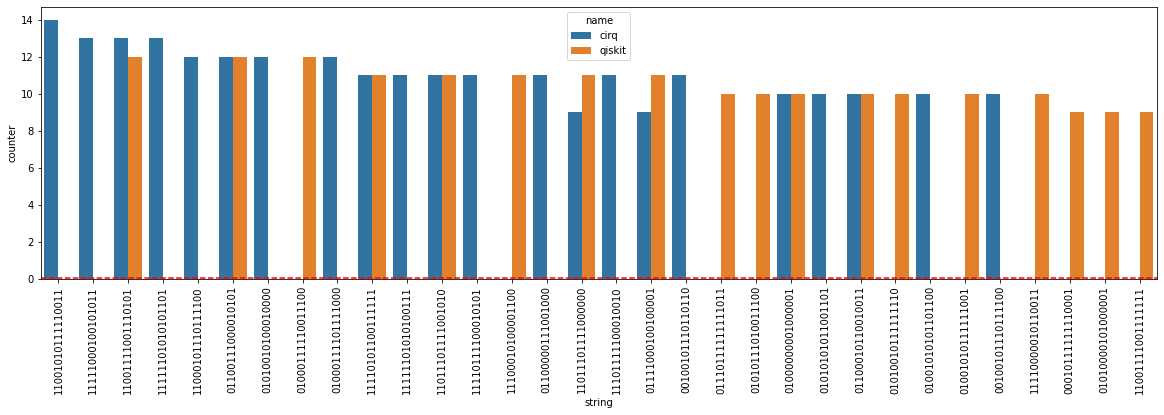

Program id: 5241
n_qubits: 16
n_shots: 8192.0
Uniform threshold: 0.125


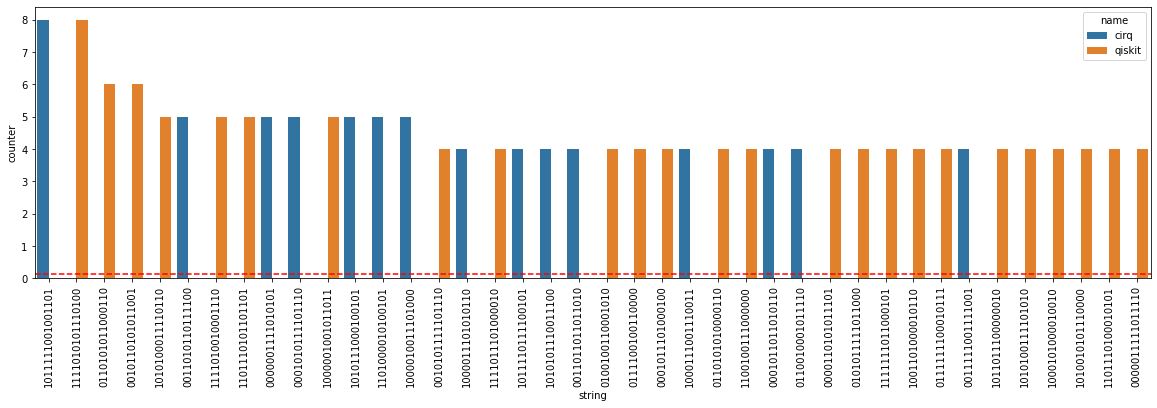

Program id: 7824
n_qubits: 4
n_shots: 8192.0
Uniform threshold: 512.0


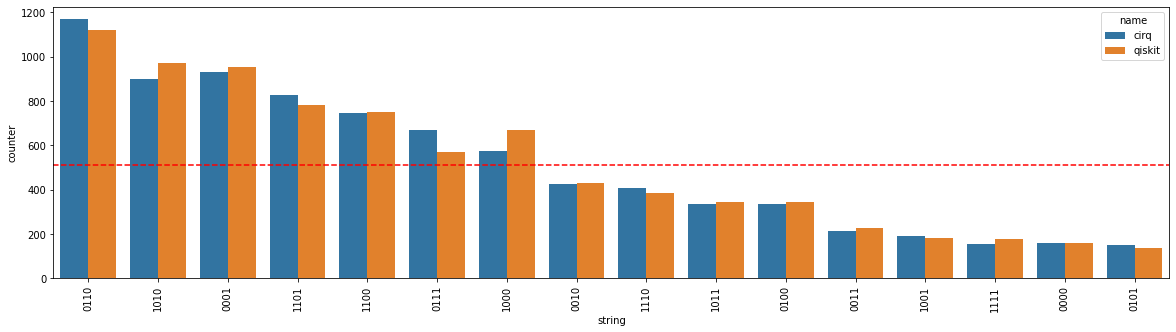

Program id: 2813
n_qubits: 14
n_shots: 8192.0
Uniform threshold: 0.5


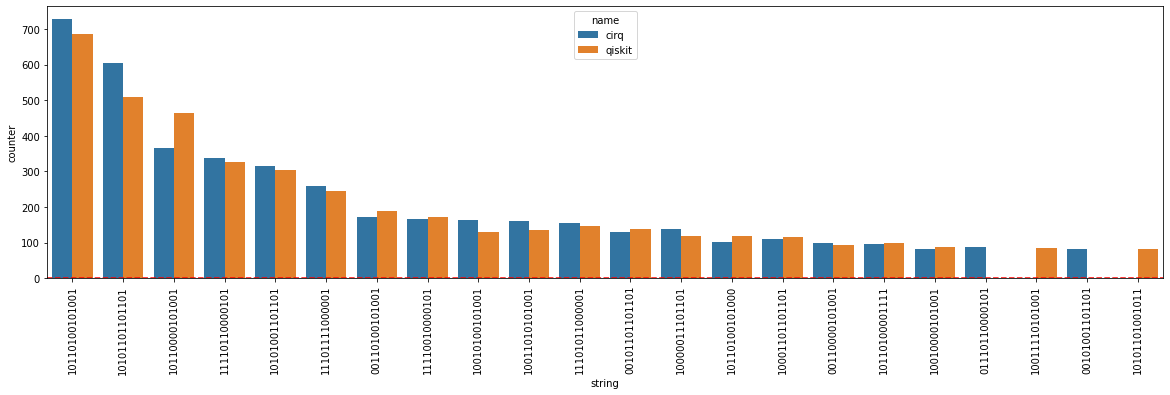

Program id: 4687
n_qubits: 12
n_shots: 8192.0
Uniform threshold: 2.0


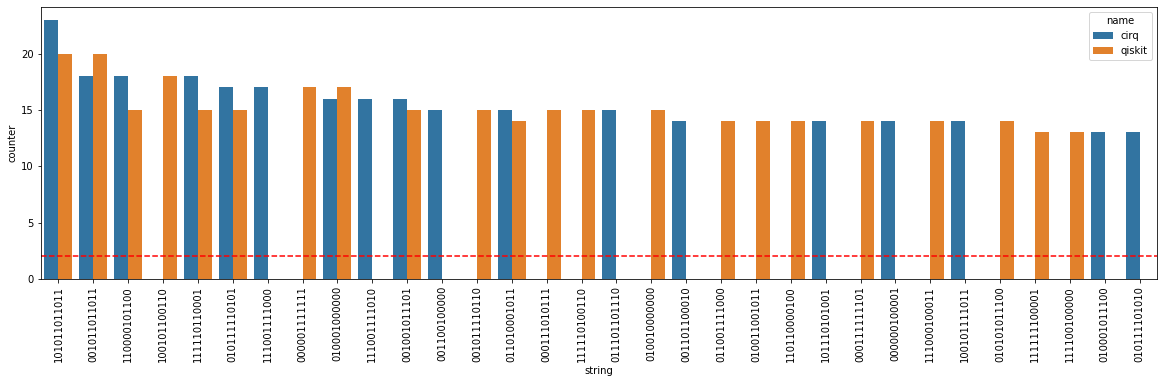

Program id: 6319
n_qubits: 17
n_shots: 8192.0
Uniform threshold: 0.0625


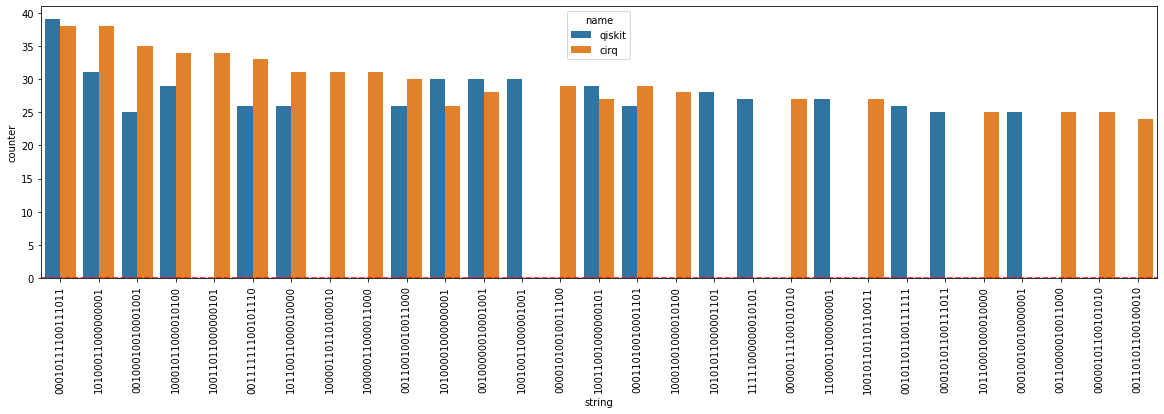

Program id: 9725
n_qubits: 7
n_shots: 8192.0
Uniform threshold: 64.0


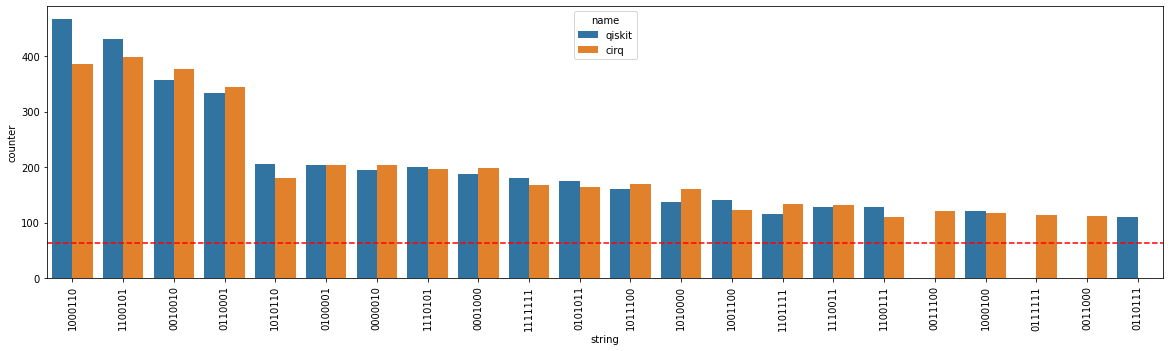

Program id: 7409
n_qubits: 20
n_shots: 8192.0
Uniform threshold: 0.0078125


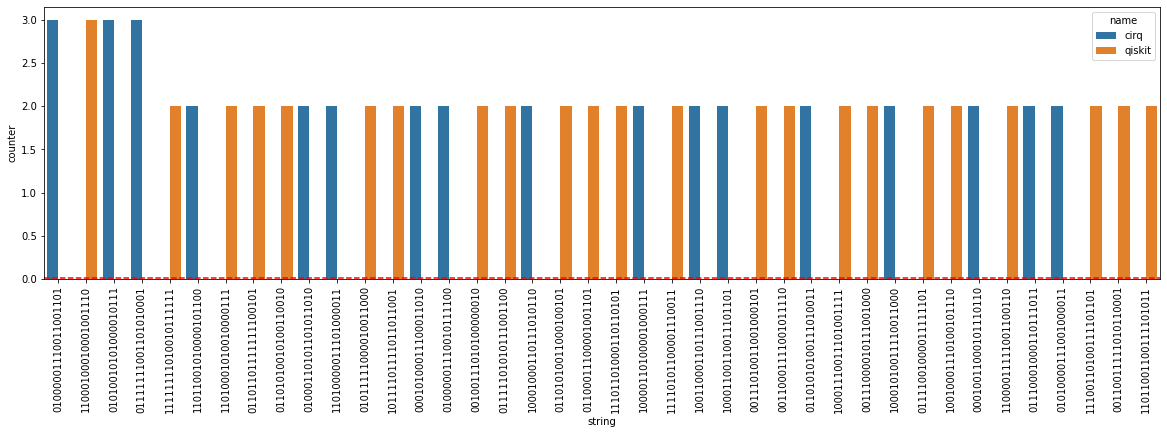

Program id: 3704
n_qubits: 18
n_shots: 8192.0
Uniform threshold: 0.03125


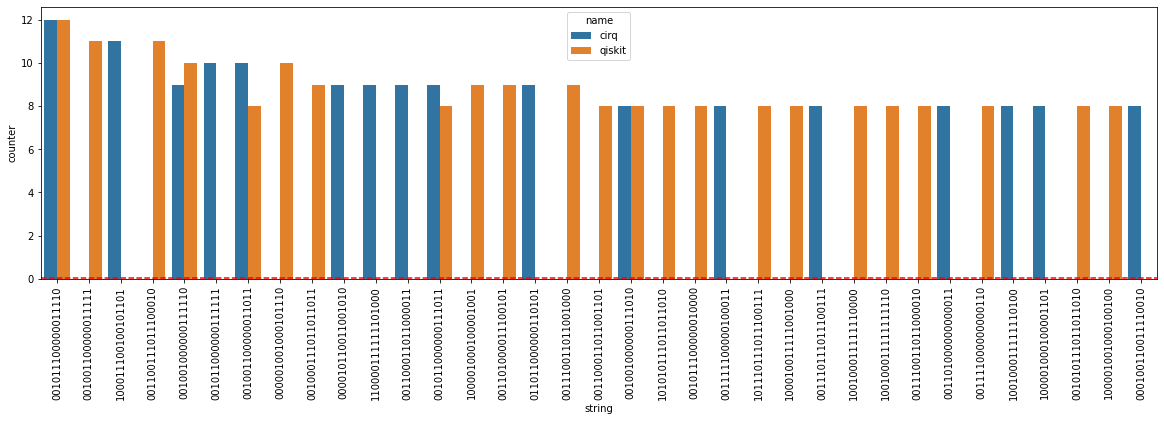

In [58]:
# ITERATE OVER THE TOP K
for k in most_serious_divergent_cases:
    df_single_test = df_single_test.assign(circuit_id=lambda d: d['circuit_id'].astype(int))
    df_single_test[df_single_test["circuit_id"] == k]
    sherlock.inspect(
        df=df_single_test, 
        divergent_id=k,
        colname_pvalue="p_value",
        colname_id="circuit_id"
    )
    print(f"Program id: {k}")
    sherlock.plot_histogram_together(
        top_perc=1, max_solutions=40, figsize=(20, 5))
    

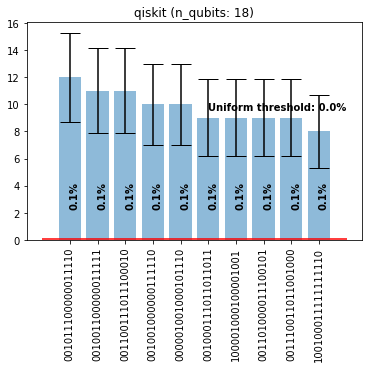

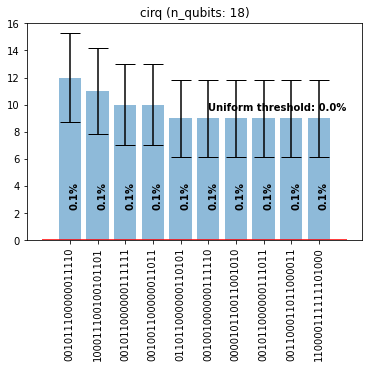

In [59]:
sherlock.plot_execution_top_k(k=10)

## Rerun Multiple times

In [36]:
from simulators import QconvertCircuit
from detectors import Faster_Energy_Detector

In [37]:
possible_bugs = [ID_TO_INSPECT]

In [39]:
#ID_UNDER_INSPECTION = 4280
detector = Faster_Energy_Detector()
N_ROUND = 10

for id_under_inspection in possible_bugs:
    qasm_path = f'{config["experiment_folder"]}cross_platform/programs/cirq/{id_under_inspection}.qasm'
    qasm_content = open(qasm_path, 'r').read()
    #simulator_cirq = QconvertCircuit(target_platform='cirq', repetitions=8192)
    #simulator_cirq.from_qasm(qasm_content)
    simulator_qiskit = QconvertCircuit(target_platform='qiskit', repetitions=8192)
    simulator_qiskit.from_qasm(qasm_content)

    executions_cirq = []
    executions_qiskit= []
    p_values = []
    stats = []
    
    for i in range(N_ROUND):
        print(f"Iteration: {i}")
        #simulator_cirq.execute()
        #res_cirq = simulator_cirq.get_result()

        simulator_qiskit.execute()
        res_qiskit = simulator_qiskit.get_result()
        raise Exception("controlled stop!")
        executions_cirq.append(res_cirq)
        executions_qiskit.append(res_qiskit)

        stat, p_value = detector.check(res_cirq, res_qiskit)
        p_values.append(p_value)
        stats.append(stat)
    
    plt.hist(p_values)
    plt.title(f"Bug id: {id_under_inspection} (small dataset)")
    plt.show()

Q-Convert - Quantum Language Converter

Usage:
    q-convert -i input_file -s source_format -o output_file -d destination_format [-j] [-w]
        -i, --input	Input file
        -s, --source	Source format: qasm, quil, qobj, quantum-circuit, toaster
        -o, --output	Output file
        -d, --dest	Destination format: qiskit, qasm, qobj, quil, pyquil, braket, cirq, tfq, qsharp, quest, js, quantum-circuit, toaster, svg, svg-inline
        -j, --jupyter	Output jupyter notebook (for qiskit, pyquil, braket, cirq, tfq, qsharp, and js only)
        -w, --overwrite	Overwrite output file if it already exists
        -h, --help	Print this help text

Enjoy! :)

Error: output file "./qconvert_tmp_cache/b97ad29af0b831fa8ca0b36e67016fe004613b00d63242054e01add8.py" already exists.
Use -w switch to overwrite.
Iteration: 0


Exception: controlled stop!